In [1]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns

In [2]:
adata = sc.read_h5ad('/home/MinaRyten/Aine/wood_full/data/raw/wood_fulldata.h5ad')

# Fixing mislabelling issues
# 1. Swap PD0779C/PDC087F
adata.obs['sample_id'] = adata.obs['sample_id'].replace('PD0779C', 'temp')
adata.obs['sample_id'] = adata.obs['sample_id'].replace('PDC087F', 'PD0779C')
adata.obs['sample_id'] = adata.obs['sample_id'].replace('temp', 'PDC087F')

# 2. Remove PDC087C
adata = adata[adata.obs['sample_id']!='PDC087C']

# 3. Filter out samples with RIN<4 AND <2500 nuclei - taken from '~/MinaRyten/Aine/wood_full/data/samples_to_remove/samples_to_remove.csv'
adata = adata[~adata.obs['sample_id'].isin(['PD0969C','PD0969F','PD0969P'])]

# 4. Fix OPC/OG mislabelling
adata.obs['annotation_level_1'] = adata.obs['annotation_level_1'].replace('OPC', 'OG')

/tmp/ipykernel_1615886/1577121986.py:16: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['annotation_level_1'] = adata.obs['annotation_level_1'].replace('OPC', 'OG')


In [3]:
adata.obs['annotation_level_2'].unique()

['OG', 'Endomural', 'Immune', 'EN', 'Astro', 'IN', 'OPC']
Categories (7, object): ['Astro', 'EN', 'Endomural', 'IN', 'Immune', 'OG', 'OPC']

In [4]:
cov = pd.read_csv("~/MinaRyten/Aine/wood_full/data/metadata/05d-final_covariates.csv", sep = '\t')
adata = adata[adata.obs['sample_id'].isin(cov['sample_id'])]

In [5]:
cov['group'] = cov['sample_id'].str.split('0', expand = True)[0]
cov['group'].replace('PDC', 'Control', inplace = True)
cov['group'].replace('C', 'Control', inplace = True)
cov['group'].replace('PD11', 'PD', inplace = True)

Plotting data...
Appending %


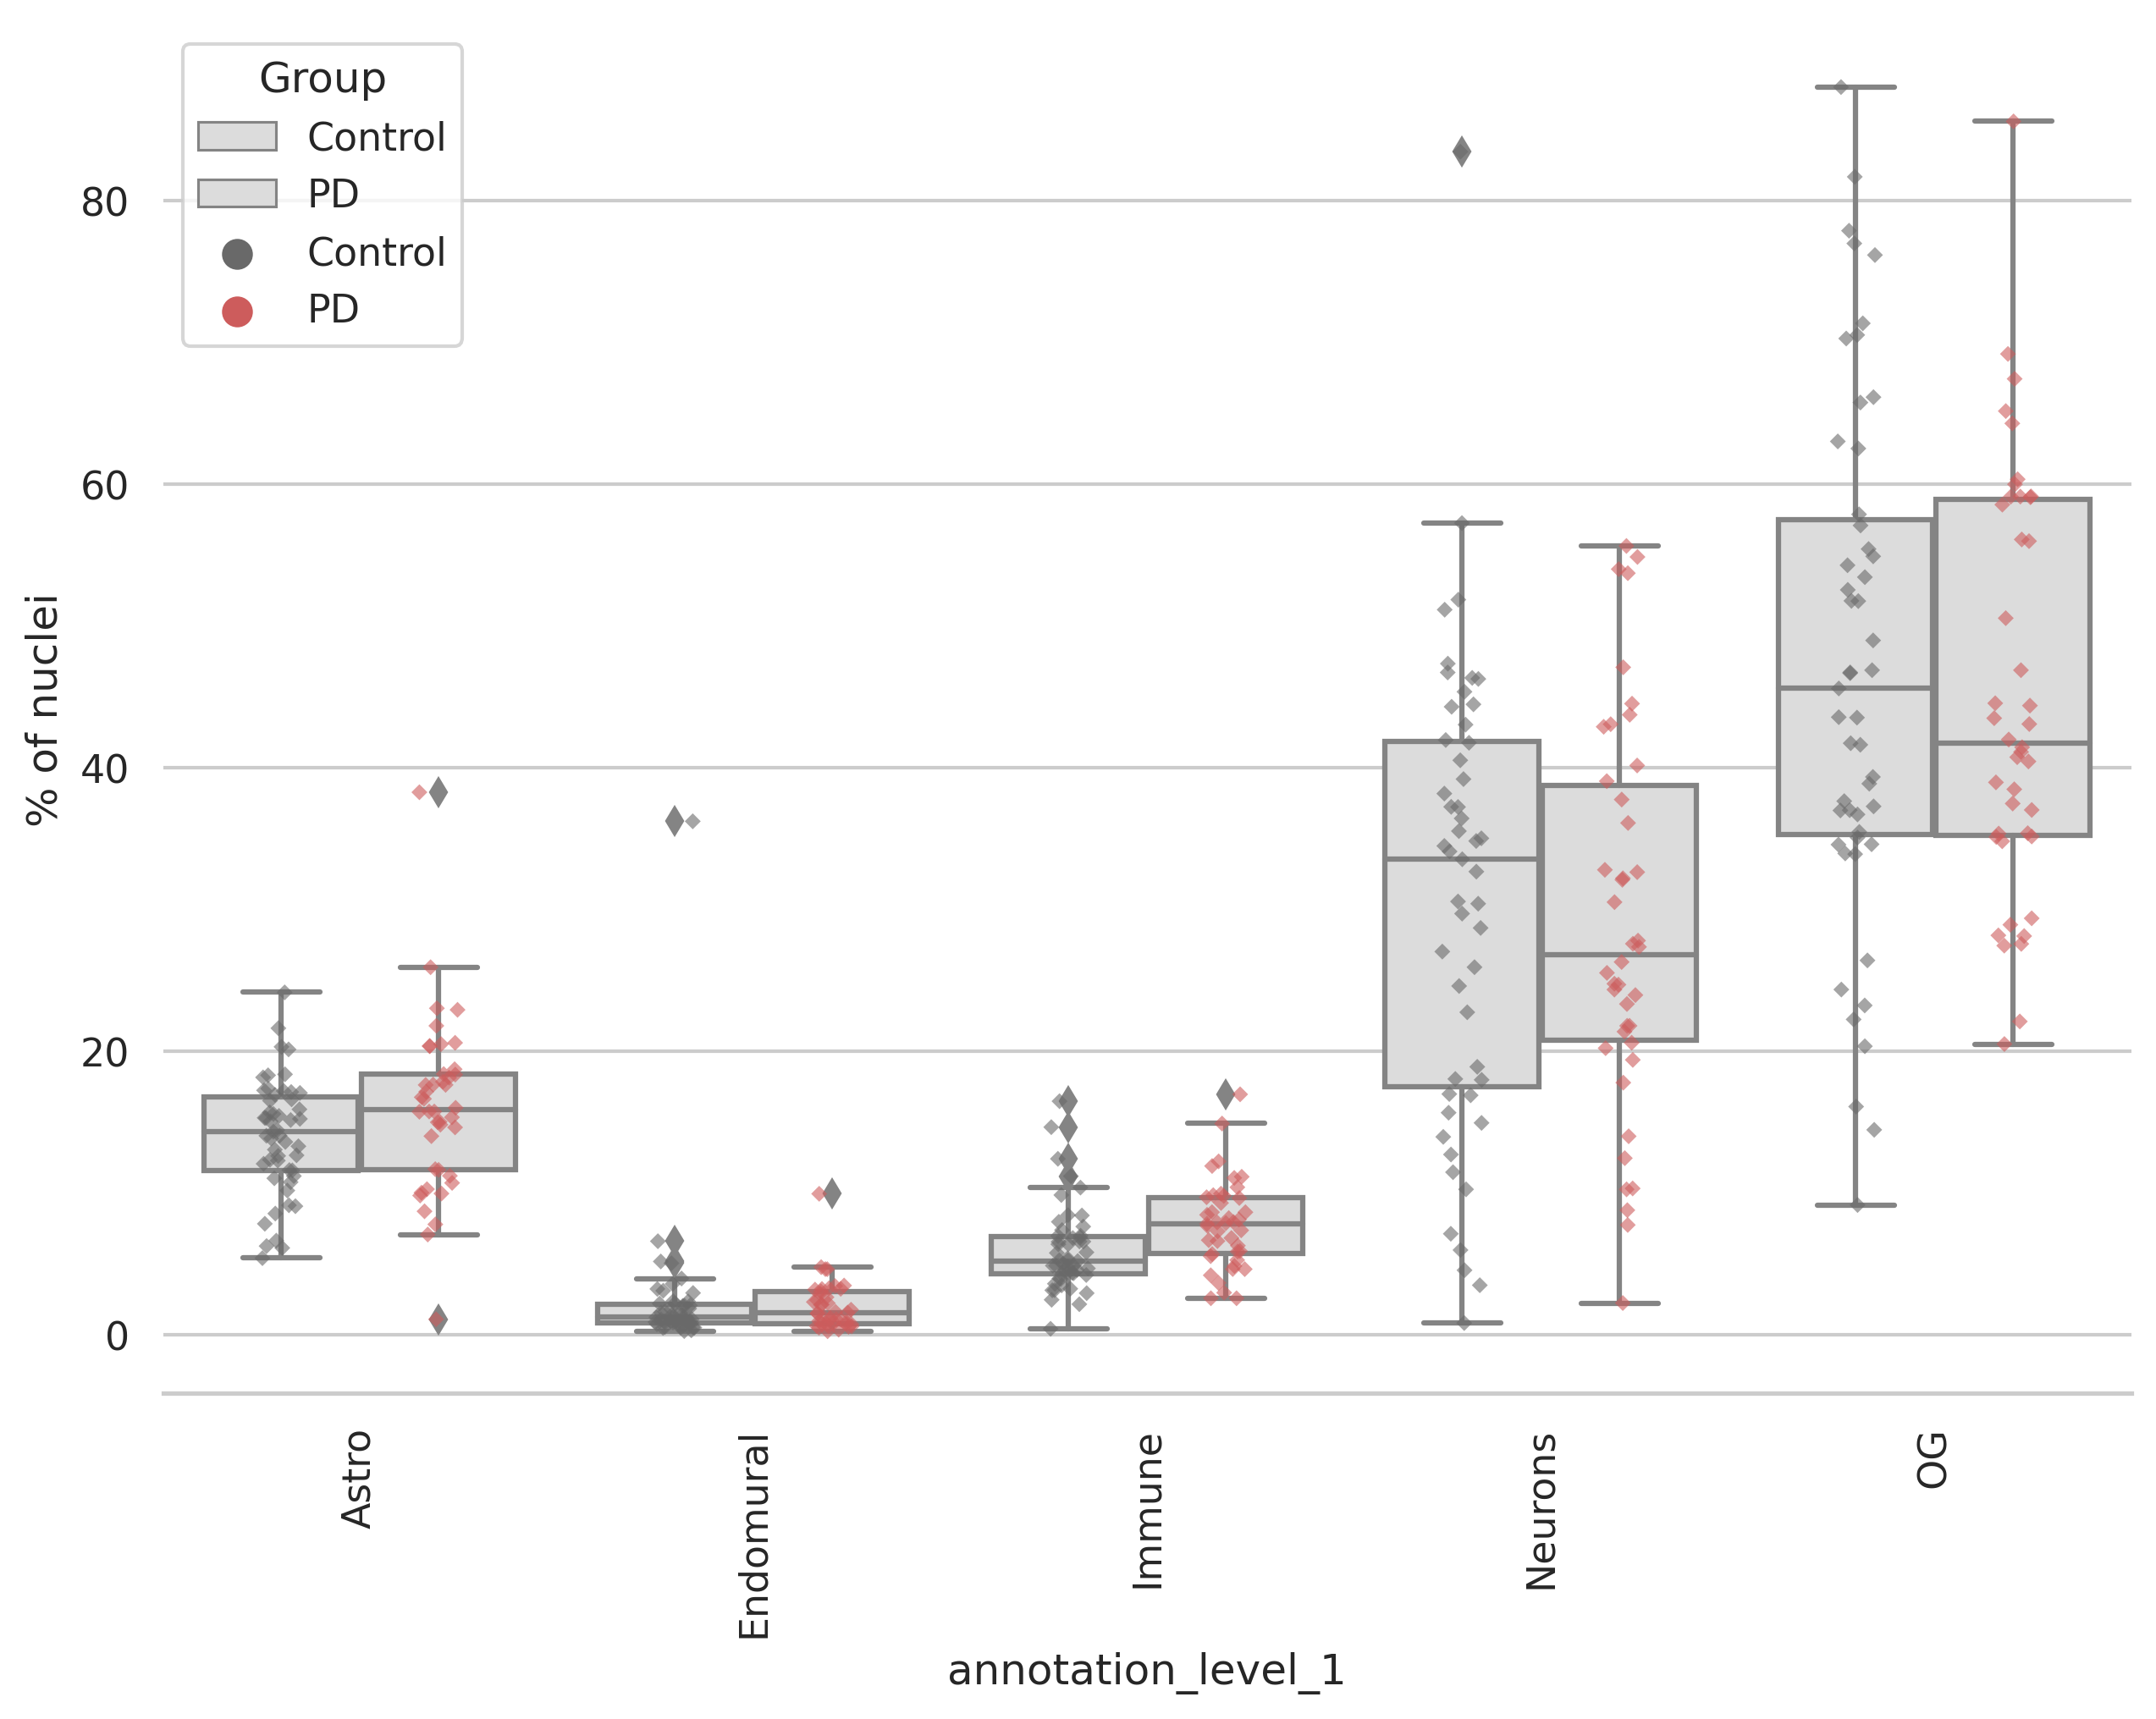

<Figure size 640x480 with 0 Axes>

In [6]:
print('Plotting data...')
def list_counts_from_pandas(df, lst):
    return df[lst].value_counts().to_frame().reset_index().rename({0:'n'}, axis=1)

sns.set_theme(style="whitegrid")
all_clust = list_counts_from_pandas(adata.obs, ['sample_id', 'annotation_level_1', 'Group'])
total_patient = list_counts_from_pandas(adata.obs, ['sample_id'])
all_clust.rename(columns = {'n':'All'}, inplace = True)
perc = []

print("Appending %")
for n in range (0,np.shape(all_clust)[0]):
    perc.append(100*all_clust['All'][n]/np.shape(adata[adata.obs['sample_id']==all_clust['sample_id'][n]])[0])

all_clust['% of nuclei'] = perc

plt.figure(figsize=(10,7), dpi = 300)
sns.boxplot(data=all_clust, x="annotation_level_1", y="% of nuclei", hue="Group",
               palette={"Control": "gainsboro", "PD": "gainsboro"}, hue_order=['Control', 'PD'])
sns.stripplot(x="annotation_level_1", y="% of nuclei" , hue = "Group",palette={"Control": "dimgray", "PD": "indianred"}, 
              dodge = True, data=all_clust, color=".2", size = 3.2,
              marker="D", alpha=.6)
plt.xticks(rotation=90)
sns.despine(left=True)
plt.savefig('plots/Abundance_annotation_level_1.png', dpi = 150, bbox_inches = 'tight')
plt.show()
plt.clf()

all_clust = all_clust.sort_values(by = 'sample_id')
pd.pivot_table(all_clust, values=['All'], index=['sample_id'],columns=['annotation_level_1'])['All'].to_csv('processed_data/counts/counts_All_Abundance_raw_annotation_level_1.csv')
cov[cov['sample_id'].isin(list(all_clust['sample_id']))].sort_values(by = 'sample_id').to_csv('processed_data/covariates/covariates_All_Abundance_raw_annotation_level_1.csv', index = False)

sns.set_theme(style="whitegrid")
buckets = list(adata.obs['annotation_level_1'].unique())

In [11]:
def boxplots_clusters(adata, ref_level, groups_list, vars_to_plot, region, color_box):
    for subset in range (0,len(groups_list)):
        print(groups_list[subset])
        if len(groups_list)>1:
            all_clust = list_counts_from_pandas(adata.obs[adata.obs[ref_level]==groups_list[subset]], ['sample_id', vars_to_plot, 'Group'])
        else:
            all_clust = list_counts_from_pandas(adata.obs, ['sample_id', vars_to_plot, 'Group'])
        total_patient = list_counts_from_pandas(adata.obs, ['sample_id'])
        all_clust.rename(columns = {'n':'All'}, inplace = True)
        perc = []
        for n in range (0,np.shape(all_clust)[0]):
            perc.append(100*all_clust['All'][n]/np.shape(adata[adata.obs['sample_id']==all_clust['sample_id'][n]])[0])

        all_clust['% of nuclei'] = perc
        np.shape(all_clust)
        sns.boxplot(data=all_clust, x=vars_to_plot, y="% of nuclei", hue="Group",
                           palette={"Control": color_box, "PD": color_box}, hue_order=['Control', 'PD'])
        sns.stripplot(x=vars_to_plot, y="% of nuclei" , hue = "Group",palette={"Control": "dimgray", "PD": "indianred"}, 
                      dodge = True, data=all_clust, color=".2", size = 5, hue_order=['Control', 'PD'],
                      marker="D", alpha=.6)
        plt.xticks(rotation=90)
        plt.xlabel('')
        sns.despine(left=True)
        plt.savefig('plots/Abundance_%s_%s_%s.png' % (region, vars_to_plot, groups_list[subset].replace('/', '')), dpi = 150, bbox_inches = 'tight')
        plt.show()
        plt.clf()
    
        print(all_clust)
        all_clust.to_csv('processed_data/percentages/pct_Abundance_raw_%s_%s_%s.csv' %(region, vars_to_plot, groups_list[subset].replace('/', '')))

        all_clust = all_clust[['sample_id', vars_to_plot, 'All']].sort_values(by = 'sample_id')
        pd.pivot_table(all_clust, values=['All'], index=['sample_id'],columns=[vars_to_plot])['All'].to_csv('processed_data/counts/counts_All_Abundance_raw_%s_%s_%s.csv' %(region, vars_to_plot, groups_list[subset].replace('/', '')))
        cov[cov['sample_id'].isin(list(all_clust['sample_id']))].sort_values(by = 'sample_id').to_csv('processed_data/covariates/covariates_All_Abundance_raw_%s_%s_%s.csv' % (region, vars_to_plot, groups_list[subset].replace('/', '')), index = False)


All


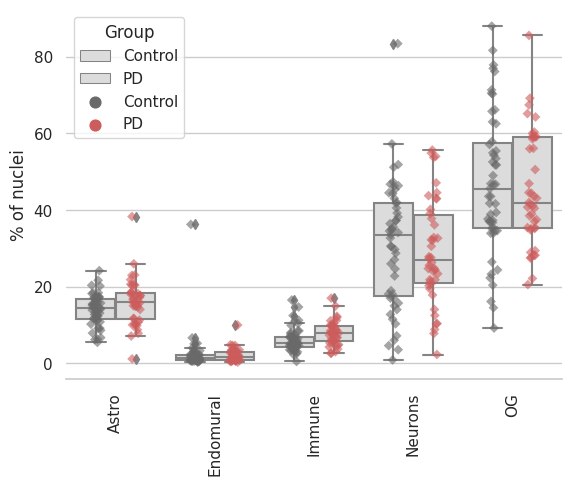

    sample_id annotation_level_1    Group    All  % of nuclei
0     PDC085F                 OG  Control  10043    55.421886
1     PDC022P                 OG  Control   9047    70.519916
2     PD0913C                 OG       PD   8909    60.342726
3     PDC034C                 OG  Control   8578    66.132141
4       C074P                 OG  Control   8480    57.868159
..        ...                ...      ...    ...          ...
460   PDC087F          Endomural       PD     26     0.503778
461     C030P             Immune  Control     22     0.424957
462   PD0822P          Endomural       PD     18     0.606265
463   PD0612C          Endomural       PD     13     0.251256
464     C076C          Endomural  Control     12     0.263158

[465 rows x 5 columns]
All


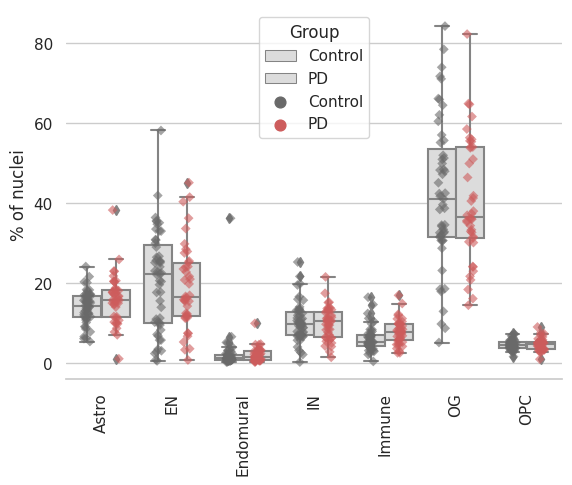

    sample_id annotation_level_2    Group   All  % of nuclei
0     PDC085F                 OG  Control  9291    51.272005
1     PDC022P                 OG  Control  8456    65.913165
2     PD0913C                 OG       PD  8173    55.357627
3       C074P                 OG  Control  8082    55.152177
4     PDC029C                 OG  Control  7915    84.246940
..        ...                ...      ...   ...          ...
646   PDC029C                 IN  Control    25     0.266099
647     C030P             Immune  Control    22     0.424957
648   PD0822P          Endomural       PD    18     0.606265
649   PD0612C          Endomural       PD    13     0.251256
650     C076C          Endomural  Control    12     0.263158

[651 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

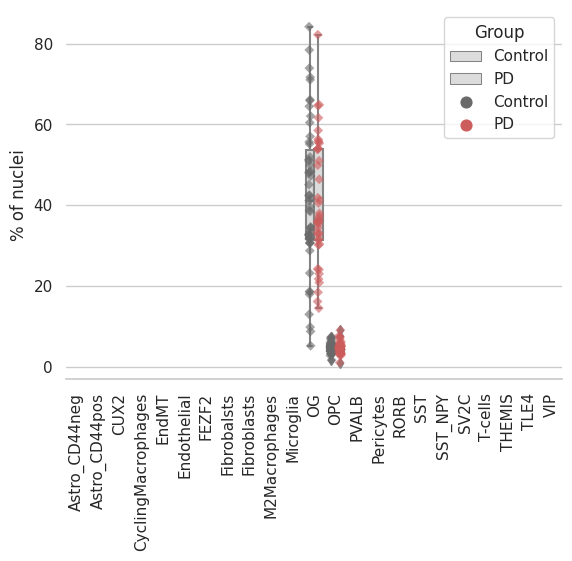

    sample_id annotation_level_3    Group   All  % of nuclei
0     PDC085F                 OG  Control  9291    51.272005
1     PDC022P                 OG  Control  8456    65.913165
2     PD0913C                 OG       PD  8173    55.357627
3       C074P                 OG  Control  8082    55.152177
4     PDC029C                 OG  Control  7915    84.246940
..        ...                ...      ...   ...          ...
181   PD0612P                OPC       PD   131     3.634850
182   PD0822P                OPC       PD   128     4.311216
183   PD0802F                OPC       PD   113     2.734753
184   PD0822F                OPC       PD   112     3.667322
185   PD0590P                OPC       PD    80     0.975253

[186 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

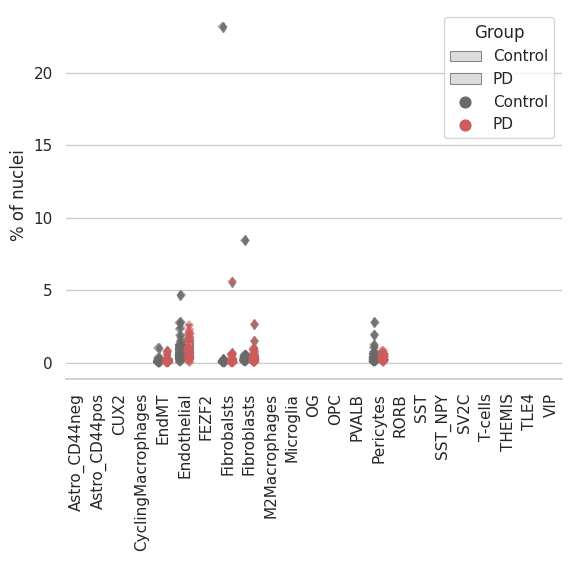

    sample_id annotation_level_3    Group   All  % of nuclei
0     PDC035F        Fibrobalsts  Control  1563    23.162418
1     PDC035F        Fibroblasts  Control   569     8.432128
2     PDC078P        Endothelial  Control   401     4.668762
3       C036P        Endothelial  Control   261     2.754908
4       C064P        Endothelial  Control   255     2.794214
..        ...                ...      ...   ...          ...
432   PD0022C        Fibrobalsts       PD     1     0.021664
433     C076C        Fibrobalsts  Control     1     0.021930
434     C075P              EndMT  Control     1     0.017406
435     C075F        Fibrobalsts  Control     1     0.031776
436     C030C              EndMT  Control     1     0.030618

[437 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

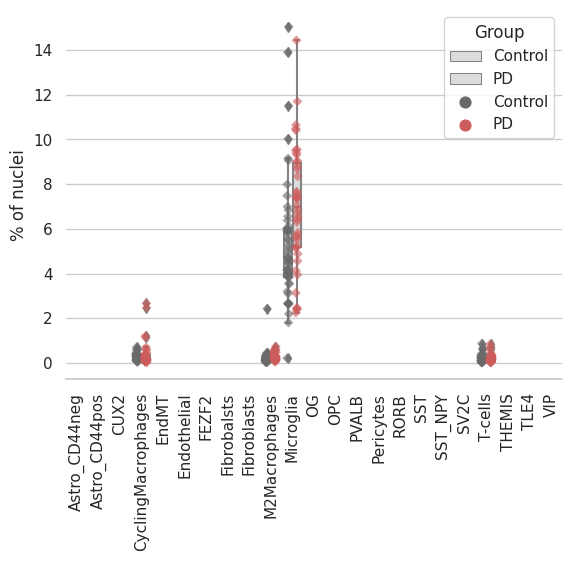

    sample_id  annotation_level_3    Group   All  % of nuclei
0     PD0913C           Microglia       PD  1727    11.697372
1       C074P           Microglia  Control  1025     6.994677
2     PD0590C           Microglia       PD   953     9.313007
3     PD0980C           Microglia       PD   919     5.836774
4     PDC035C           Microglia  Control   889    13.897139
..        ...                 ...      ...   ...          ...
365     C076C             T-cells  Control     1     0.021930
366     C076F  CyclingMacrophages  Control     1     0.030788
367   PD0022P             T-cells       PD     1     0.021664
368   PDC087F  CyclingMacrophages       PD     1     0.019376
369   PD0022C             T-cells       PD     1     0.021664

[370 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

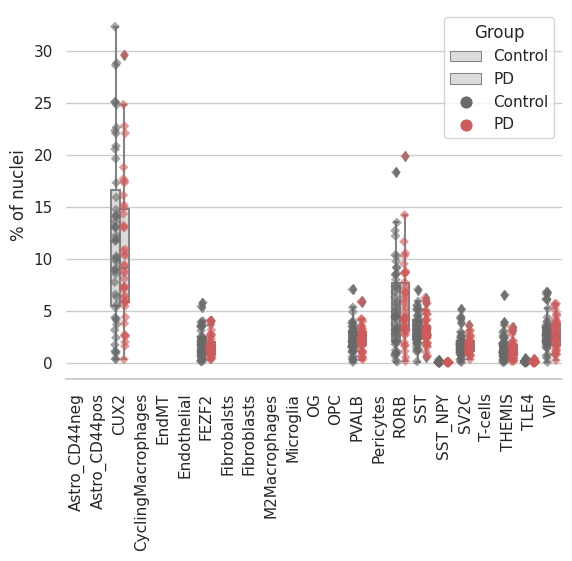

    sample_id annotation_level_3    Group   All  % of nuclei
0     PD0980C               CUX2       PD  3588    22.788187
1     PDC023C               CUX2  Control  3050    28.855251
2       C073P               CUX2  Control  2997    28.638318
3       C036P               CUX2  Control  2377    25.089719
4     PD0086P               CUX2       PD  2214    29.638554
..        ...                ...      ...   ...          ...
896   PDC034F            SST_NPY  Control     1     0.013935
897   PDC029C            SST_NPY  Control     1     0.010644
898   PDC027F               TLE4  Control     1     0.012038
899     C074F            SST_NPY  Control     1     0.011128
900   PD0709C            SST_NPY       PD     1     0.013860

[901 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

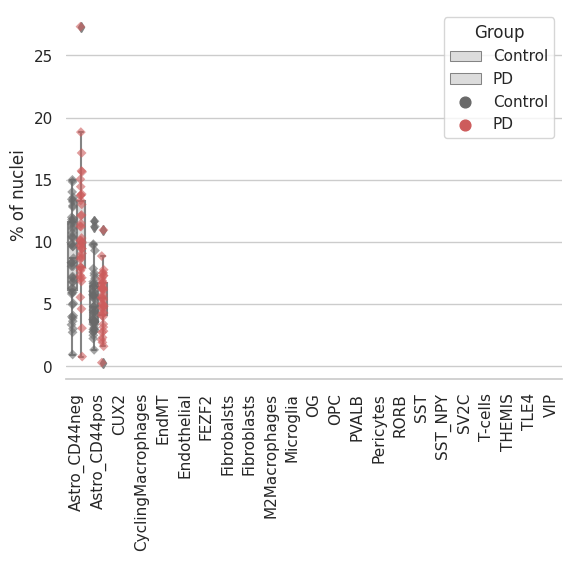

    sample_id annotation_level_3    Group   All  % of nuclei
0       C074P      Astro_CD44neg  Control  1878    12.815613
1     PD0109F      Astro_CD44neg       PD  1722    12.173913
2     PDC085P      Astro_CD44neg  Control  1647    10.740837
3     PD0945C      Astro_CD44neg       PD  1460    17.154271
4     PD0980C      Astro_CD44neg       PD  1430     9.082248
..        ...                ...      ...   ...          ...
181   PDC029C      Astro_CD44neg  Control    90     0.957956
182     C030P      Astro_CD44pos  Control    69     1.332818
183   PD0802F      Astro_CD44pos       PD    67     1.621491
184   PD0590P      Astro_CD44neg       PD    65     0.792393
185   PD0590P      Astro_CD44pos       PD    25     0.304767

[186 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

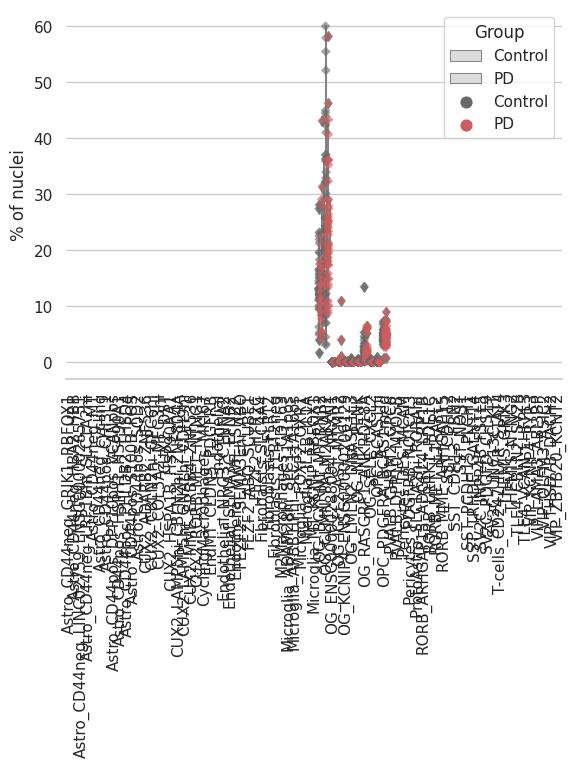

    sample_id  annotation_level_4    Group   All  % of nuclei
0     PDC034C  OG_CLMN_PALM2AKAP2  Control  5326    41.060828
1     PDC022P  OG_CLMN_PALM2AKAP2  Control  4671    36.409697
2     PDC029F  OG_CLMN_PALM2AKAP2  Control  4605    55.508679
3       C074P  OG_CLMN_PALM2AKAP2  Control  4419    30.155589
4     PDC034F  OG_CLMN_PALM2AKAP2  Control  4310    60.061315
..        ...                 ...      ...   ...          ...
925   PD0822C         OPC_BCAS1hi       PD     1     0.030075
926   PD0822F         OG_NPY_PENK       PD     1     0.032744
927     C074P         OPC_BCAS1hi  Control     1     0.006824
928   PD0822P   OG_LMLN2_DNASE1L3       PD     1     0.033681
929     C074C         OPC_BCAS1hi  Control     1     0.010983

[930 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

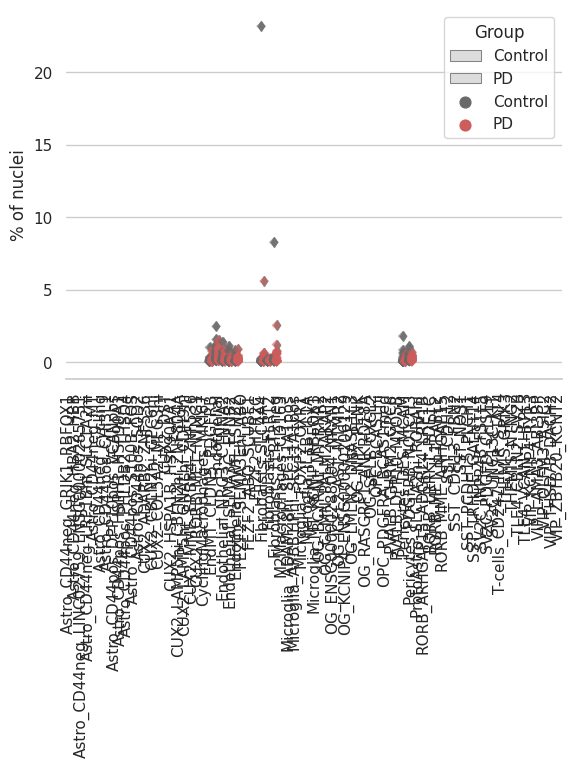

    sample_id     annotation_level_4    Group   All  % of nuclei
0     PDC035F     Fibrobalsts_SLC4A4  Control  1563    23.162418
1     PDC035F   Fibroblasts_FLRT2neg  Control   558     8.269117
2     PD0802F     Fibrobalsts_SLC4A4       PD   231     5.590513
3     PDC078P            Endothelial  Control   212     2.468273
4       C064P            Endothelial  Control   143     1.566952
..        ...                    ...      ...   ...          ...
851     C075F  Endothelial_VWF_TSHZ2  Control     1     0.031776
852   PD0945P     Pericytes_DES_MCAM       PD     1     0.010541
853     C075F     Fibrobalsts_SLC4A4  Control     1     0.031776
854     C075P     EndMT_CLDN5_PDGFRB  Control     1     0.017406
855     C030C     EndMT_CLDN5_PDGFRB  Control     1     0.030618

[856 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

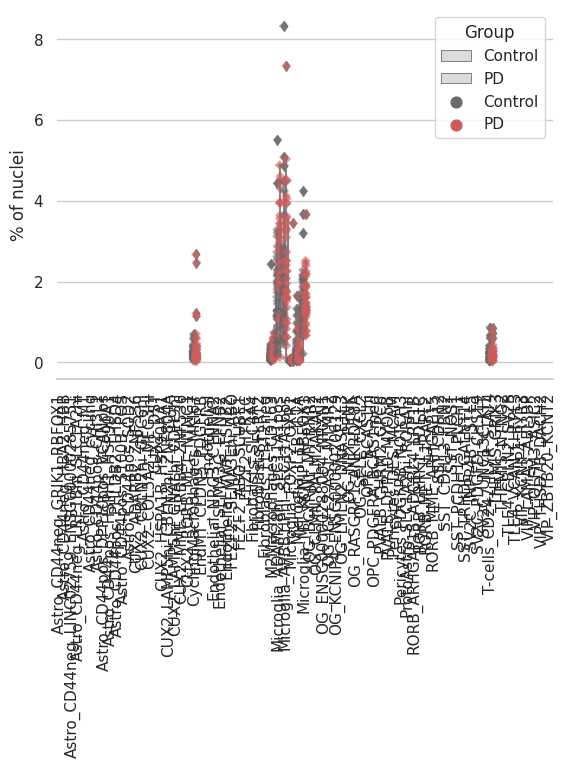

    sample_id              annotation_level_4    Group  All  % of nuclei
0     PD0913C   Microglia_ADAM28hi_SLC11A1pos       PD  664     4.497426
1     PDC035C  Microglia_APBB1IPhi_SLC11A1pos  Control  532     8.316398
2     PD0913C            Microglia_FOXP2_OXR1       PD  508     3.440802
3     PD0590C  Microglia_APBB1IPhi_SLC11A1pos       PD  462     4.514805
4       C074P   Microglia_ADAM28hi_SLC11A1pos  Control  421     2.872936
..        ...                             ...      ...  ...          ...
697   PD0945P            Microglia_FOXP2_OXR1       PD    1     0.010541
698   PD0976P            Microglia_FOXP2_OXR1       PD    1     0.016529
699     C075F        T-cells_CD247_IL7R_STAT4  Control    1     0.031776
700     C073F            Microglia_FOXP2_OXR1  Control    1     0.012867
701     C075P            Microglia_FOXP2_OXR1  Control    1     0.017406

[702 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

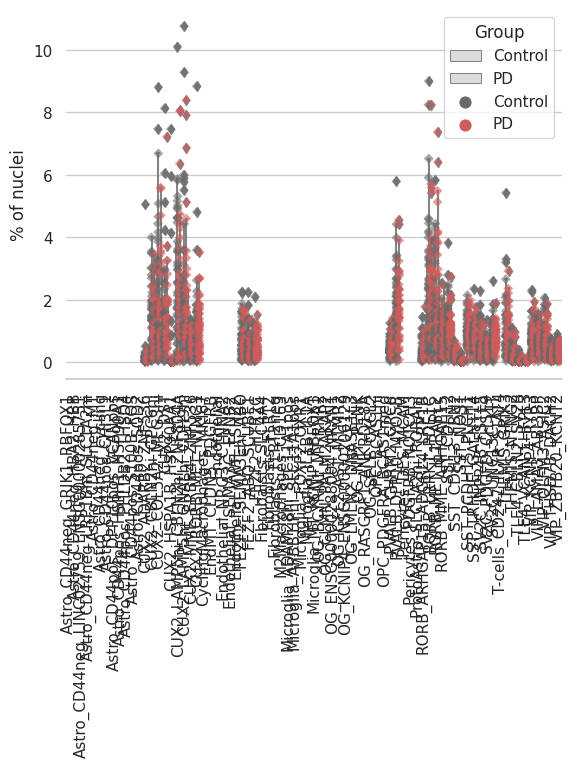

     sample_id          annotation_level_4    Group   All  % of nuclei
0      PDC085P            RORB_LRRK1_PDE1C  Control  1000     6.521456
1        C073P         CUX2_RORB_MET_NTNG1  Control   925     8.838987
2      PD0980C          CUX2_COL5A2_MEG3hi       PD   876     5.563671
3      PD0980C            RORB_LRRK1_PDE1C       PD   854     5.423944
4      PD0980C  CUX2_LAMP5hi_GNALhi_CDH9hi       PD   807     5.125437
...        ...                         ...      ...   ...          ...
3099   PD0596P        CUX2_HSPA1B_HSP90AA1       PD     1     0.015780
3100   PDC035C            TLE4_VCAN_LHFPL3  Control     1     0.015632
3101   PD0590P            TLE4_VCAN_LHFPL3       PD     1     0.012191
3102     C064F        CUX2_HSPA1B_HSP90AA1  Control     1     0.013068
3103   PD0596C             TLE4_CBLN2_SV2B       PD     1     0.011614

[3104 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level
/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise com

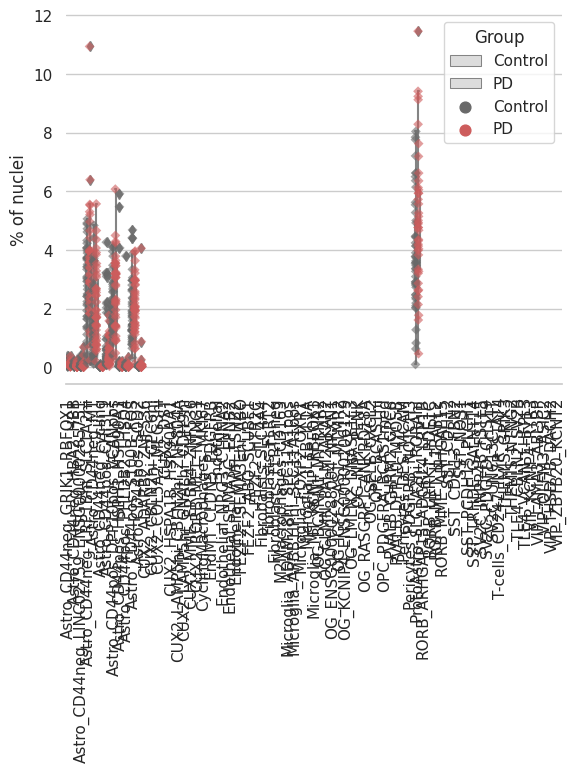

     sample_id                       annotation_level_4    Group   All  \
0        C074P               ProtoAstro_SLC1A2hi_RORAhi  Control  1137   
1      PD0109F               ProtoAstro_SLC1A2hi_RORAhi       PD   899   
2      PD0109P               ProtoAstro_SLC1A2hi_RORAhi       PD   852   
3      PD0945C               ProtoAstro_SLC1A2hi_RORAhi       PD   786   
4      PD0913C           Astro_CD44neg_LRP1Bhi_SLC1A2hi       PD   783   
...        ...                                      ...      ...   ...   
1057   PD0913F               Astro_CD44pos_PHLDB2_THSD4       PD     1   
1058   PD0913P                   Astro_CD44neg_HBA2_HBB       PD     1   
1059   PD0913P                    Astro_CD44neg_cycling       PD     1   
1060   PD0917C  Astro_CD44neg_LINC02759_ENSG00000285751       PD     1   
1061   PD0687P                   Astro_CD44neg_HBA2_HBB       PD     1   

      % of nuclei  
0        7.758974  
1        6.355603  
2        9.409166  
3        9.235108  
4        5.

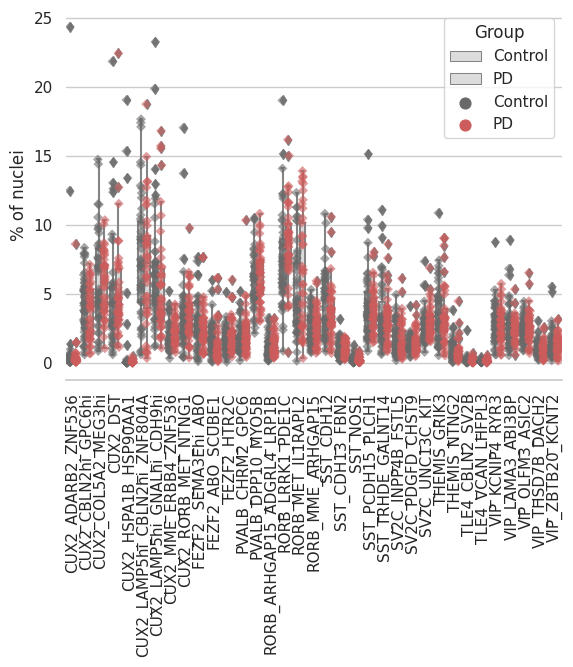

     sample_id          annotation_level_4    Group   All  % of nuclei
0      PDC085P            RORB_LRRK1_PDE1C  Control  1000    15.153811
1        C073P         CUX2_RORB_MET_NTNG1  Control   925    17.047549
2      PD0980C          CUX2_COL5A2_MEG3hi       PD   876    10.357058
3      PD0980C            RORB_LRRK1_PDE1C       PD   854    10.096950
4      PD0980C  CUX2_LAMP5hi_GNALhi_CDH9hi       PD   807     9.541263
...        ...                         ...      ...   ...          ...
3099   PD0596P        CUX2_HSPA1B_HSP90AA1       PD     1     0.048356
3100   PDC035C            TLE4_VCAN_LHFPL3  Control     1     0.033738
3101   PD0590P            TLE4_VCAN_LHFPL3       PD     1     0.021911
3102     C064F        CUX2_HSPA1B_HSP90AA1  Control     1     0.034235
3103   PD0596C             TLE4_CBLN2_SV2B       PD     1     0.049776

[3104 rows x 5 columns]
All


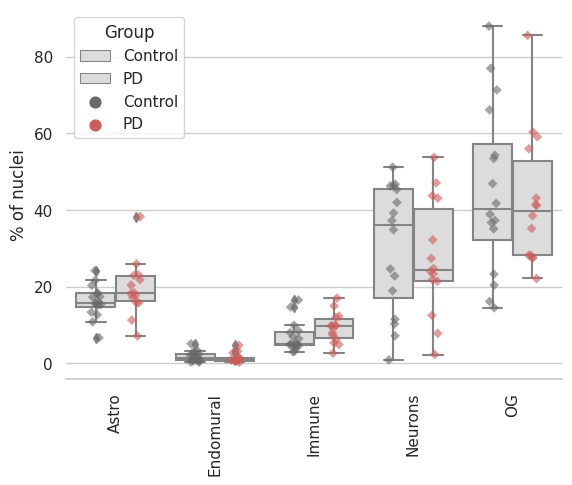

    sample_id annotation_level_1    Group   All  % of nuclei
0     PD0913C                 OG       PD  8909    60.342726
1     PDC034C                 OG  Control  8578    66.132141
2     PD0980C            Neurons       PD  8458    53.718641
3     PDC029C                 OG  Control  8268    88.004258
4     PDC085C            Neurons  Control  5051    41.951827
..        ...                ...      ...   ...          ...
145     C074C          Endomural  Control    29     0.318506
146   PD0109C          Endomural       PD    26     0.616845
147   PDC087F          Endomural       PD    26     0.503778
148   PD0612C          Endomural       PD    13     0.251256
149     C076C          Endomural  Control    12     0.263158

[150 rows x 5 columns]
All


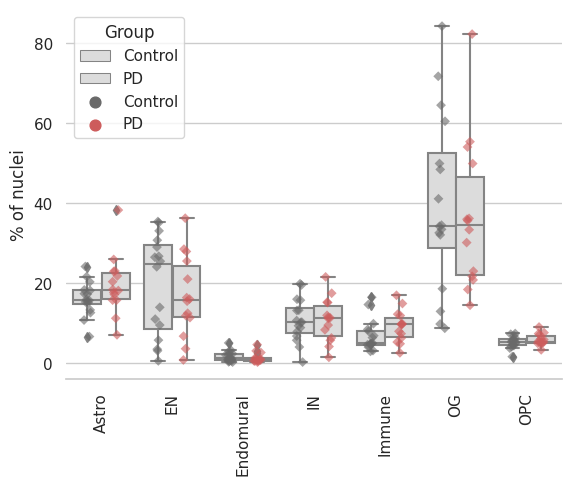

    sample_id annotation_level_2    Group   All  % of nuclei
0     PD0913C                 OG       PD  8173    55.357627
1     PDC029C                 OG  Control  7915    84.246940
2     PDC034C                 OG  Control  7842    60.457945
3     PD0980C                 EN       PD  5706    36.240076
4       C074C                 OG  Control  4544    49.906645
..        ...                ...      ...   ...          ...
205   PDC087F          Endomural       PD    26     0.503778
206   PD0109C          Endomural       PD    26     0.616845
207   PDC029C                 IN  Control    25     0.266099
208   PD0612C          Endomural       PD    13     0.251256
209     C076C          Endomural  Control    12     0.263158

[210 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


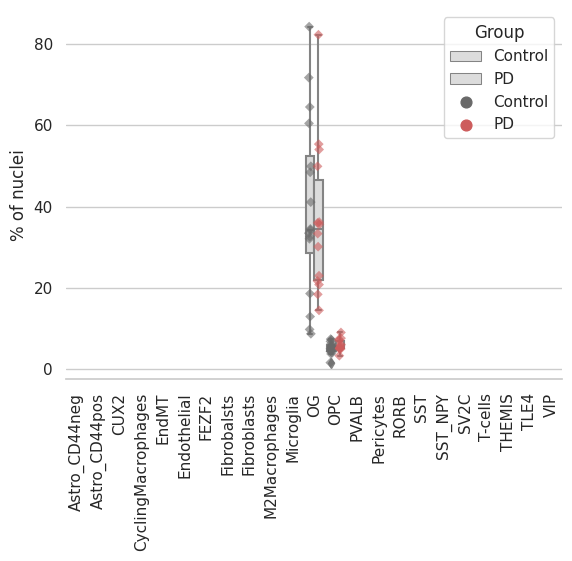

   sample_id annotation_level_3    Group   All  % of nuclei
0    PD0913C                 OG       PD  8173    55.357627
1    PDC029C                 OG  Control  7915    84.246940
2    PDC034C                 OG  Control  7842    60.457945
3      C074C                 OG  Control  4544    49.906645
4    PD0612C                 OG       PD  4256    82.257441
5    PD1101C                 OG       PD  4205    49.893213
6    PDC085C                 OG  Control  3922    32.574751
7    PDC023C                 OG  Control  3536    33.453169
8    PD0980C                 OG       PD  3276    20.806605
9      C076C                 OG  Control  3270    71.710526
10   PD0596C                 OG       PD  3098    35.981417
11     C049C                 OG  Control  2675    48.425054
12     C073C                 OG  Control  2597    34.497875
13   PDC027C                 OG  Control  2533    34.211237
14   PD0086C                 OG       PD  2524    30.133715
15     C036C                 OG  Control

/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


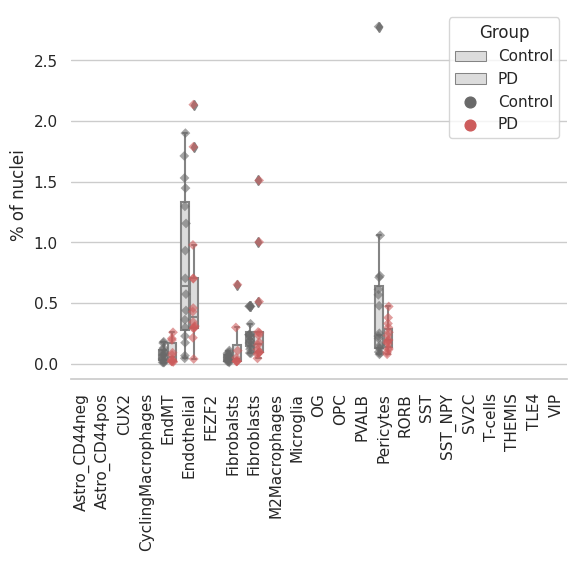

    sample_id annotation_level_3    Group  All  % of nuclei
0       C043C          Pericytes  Control  159     2.778749
1     PD0709C        Endothelial       PD  129     1.787942
2       C064C        Endothelial  Control  119     1.447336
3     PD0709C        Fibroblasts       PD  109     1.510742
4       C049C        Endothelial  Control  105     1.900797
..        ...                ...      ...  ...          ...
131     C049C        Fibrobalsts  Control    1     0.018103
132     C073C              EndMT  Control    1     0.013284
133   PD0612C        Fibrobalsts       PD    1     0.019327
134   PD0022C        Fibrobalsts       PD    1     0.021664
135     C030C              EndMT  Control    1     0.030618

[136 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


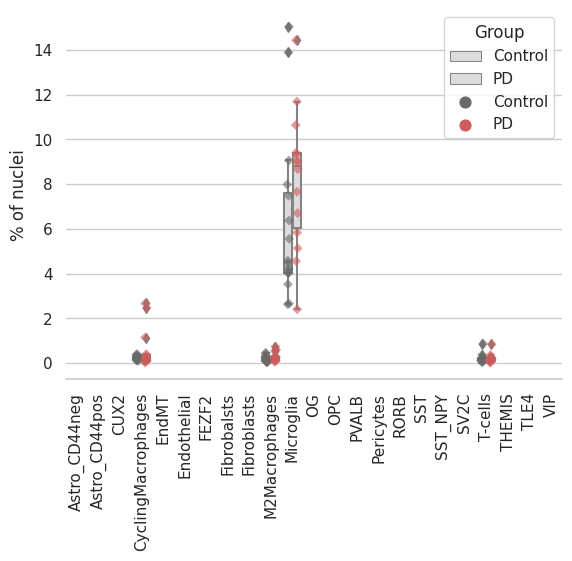

    sample_id  annotation_level_3    Group   All  % of nuclei
0     PD0913C           Microglia       PD  1727    11.697372
1     PD0590C           Microglia       PD   953     9.313007
2     PD0980C           Microglia       PD   919     5.836774
3     PDC035C           Microglia  Control   889    13.897139
4     PDC034C           Microglia  Control   827     6.375761
..        ...                 ...      ...   ...          ...
114   PDC087F             T-cells       PD     3     0.058128
115   PD0022C             T-cells       PD     1     0.021664
116   PDC087F  CyclingMacrophages       PD     1     0.019376
117     C036C       M2Macrophages  Control     1     0.025773
118     C076C             T-cells  Control     1     0.021930

[119 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


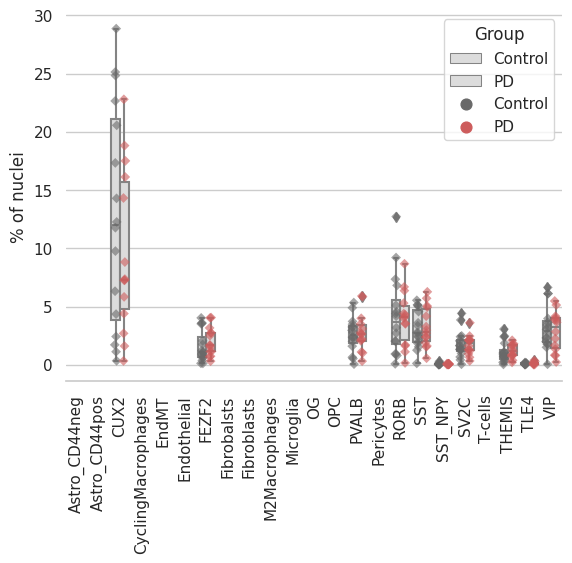

    sample_id annotation_level_3    Group   All  % of nuclei
0     PD0980C               CUX2       PD  3588    22.788187
1     PDC023C               CUX2  Control  3050    28.855251
2       C064C               CUX2  Control  1862    22.646558
3     PD0590C               CUX2       PD  1791    17.502199
4     PDC085C               CUX2  Control  1720    14.285714
..        ...                ...      ...   ...          ...
285     C030C            SST_NPY  Control     1     0.030618
286   PDC087F            SST_NPY       PD     1     0.019376
287   PD0612C            SST_NPY       PD     1     0.019327
288   PDC035C               TLE4  Control     1     0.015632
289   PDC078C               TLE4  Control     1     0.015813

[290 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


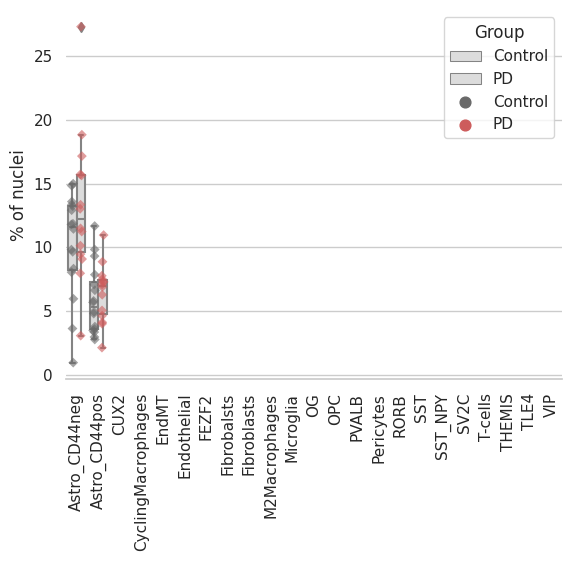

   sample_id annotation_level_3    Group   All  % of nuclei
0    PD0945C      Astro_CD44neg       PD  1460    17.154271
1    PD0980C      Astro_CD44neg       PD  1430     9.082248
2    PDC085C      Astro_CD44neg  Control  1427    11.852159
3    PD0590C      Astro_CD44neg       PD  1365    13.339197
4    PDC023C      Astro_CD44neg  Control  1365    12.913907
5      C074C      Astro_CD44neg  Control  1365    14.991763
6    PD0596C      Astro_CD44neg       PD  1353    15.714286
7    PD0913C      Astro_CD44neg       PD  1176     7.965321
8    PD0109C      Astro_CD44neg       PD  1151    27.307236
9    PD0913C      Astro_CD44pos       PD  1147     7.768897
10     C064C      Astro_CD44neg  Control  1117    13.585502
11   PDC034C      Astro_CD44neg  Control  1044     8.048724
12   PDC034C      Astro_CD44pos  Control  1019     7.855986
13     C073C      Astro_CD44neg  Control  1006    13.363443
14   PD0917C      Astro_CD44neg       PD   966    18.830409
15   PD0086C      Astro_CD44neg       PD

/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


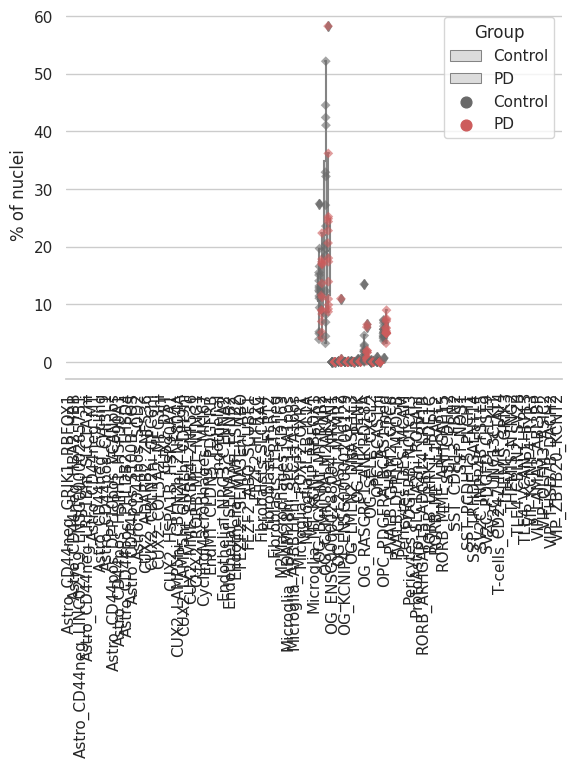

    sample_id        annotation_level_4    Group   All  % of nuclei
0     PDC034C        OG_CLMN_PALM2AKAP2  Control  5326    41.060828
1     PDC029C        OG_CLMN_PALM2AKAP2  Control  3984    42.405535
2     PD0913C        OG_CLMN_PALM2AKAP2       PD  3725    25.230290
3     PD0612C        OG_CLMN_PALM2AKAP2       PD  3013    58.233475
4       C074C        OG_CLMN_PALM2AKAP2  Control  2931    32.191104
..        ...                       ...      ...   ...          ...
292   PD0109C               OPC_BCAS1hi       PD     1     0.023725
293   PDC034C  OG_ENSG00000288004_NRXN1  Control     1     0.007710
294   PD0109C             OG_SELE_CXCL2       PD     1     0.023725
295   PD0109C         OG_LMLN2_DNASE1L3       PD     1     0.023725
296   PD0596C               OPC_BCAS1hi       PD     1     0.011614

[297 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


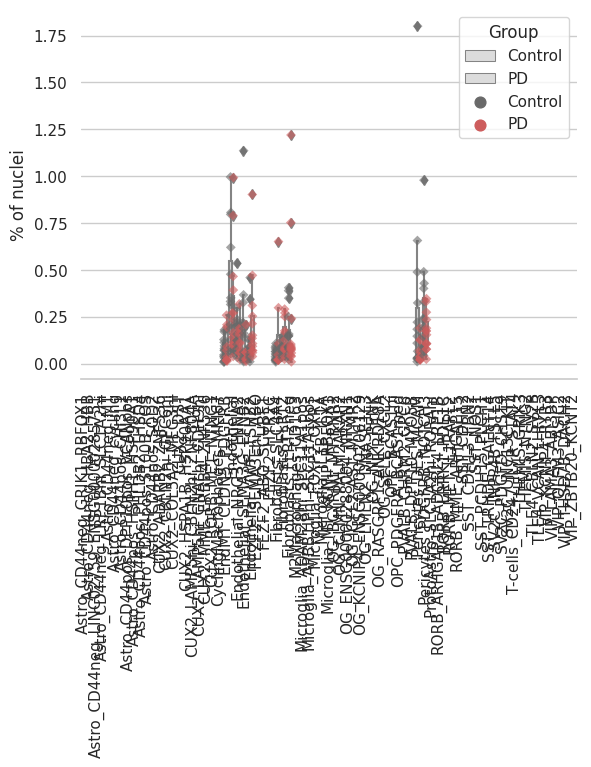

    sample_id        annotation_level_4    Group  All  % of nuclei
0       C043C        Pericytes_DES_MCAM  Control  103     1.800070
1     PD0709C      Fibroblasts_FLRT2neg       PD   88     1.219681
2       C043C  Endothelial_SEMA3G_EFNB2  Control   65     1.135966
3     PD0086C      Fibroblasts_FLRT2neg       PD   63     0.752149
4     PD0913C               Endothelial       PD   58     0.392847
..        ...                       ...      ...  ...          ...
257   PD0917C        Fibrobalsts_SLC4A4       PD    1     0.019493
258     C036C  Endothelial_SEMA3G_EFNB2  Control    1     0.025773
259   PDC029C  Endothelial_SEMA3G_EFNB2  Control    1     0.010644
260   PDC029C        EndMT_CLDN5_PDGFRB  Control    1     0.010644
261     C030C        EndMT_CLDN5_PDGFRB  Control    1     0.030618

[262 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


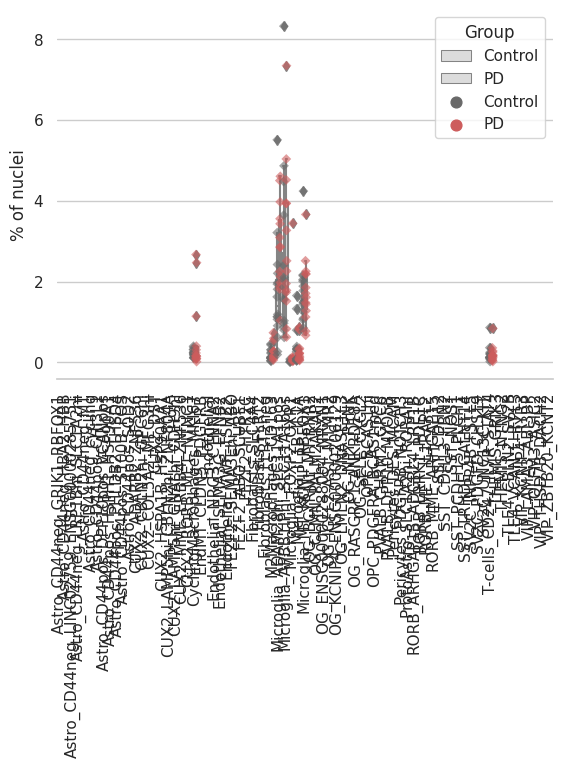

    sample_id              annotation_level_4    Group  All  % of nuclei
0     PD0913C   Microglia_ADAM28hi_SLC11A1pos       PD  664     4.497426
1     PDC035C  Microglia_APBB1IPhi_SLC11A1pos  Control  532     8.316398
2     PD0913C            Microglia_FOXP2_OXR1       PD  508     3.440802
3     PD0590C  Microglia_APBB1IPhi_SLC11A1pos       PD  462     4.514805
4     PD0913C        CyclingMacrophages_MKI67       PD  394     2.668653
..        ...                             ...      ...  ...          ...
221   PD0022C        T-cells_CD247_IL7R_STAT4       PD    1     0.021664
222   PDC087F        CyclingMacrophages_MKI67       PD    1     0.019376
223   PDC034C            Microglia_FOXP2_OXR1  Control    1     0.007710
224     C076C        T-cells_CD247_IL7R_STAT4  Control    1     0.021930
225   PDC029C            Microglia_FOXP2_OXR1  Control    1     0.010644

[226 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


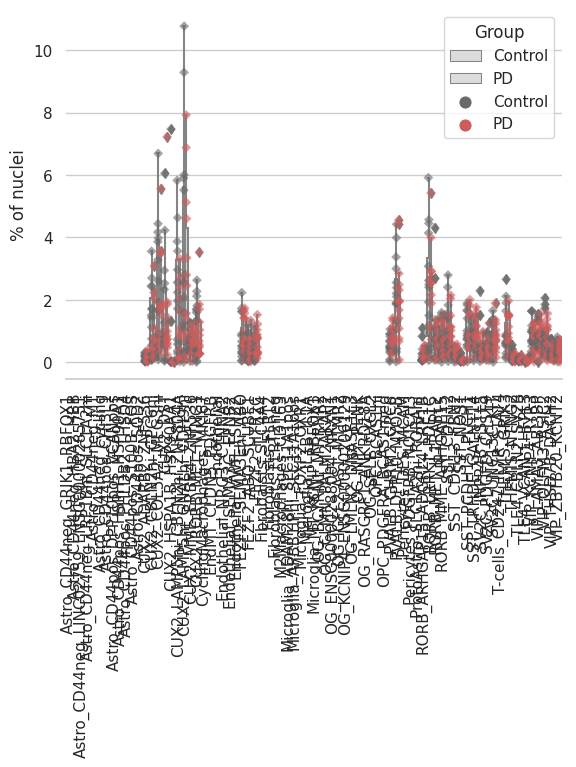

    sample_id          annotation_level_4    Group  All  % of nuclei
0     PD0980C          CUX2_COL5A2_MEG3hi       PD  876     5.563671
1     PD0980C            RORB_LRRK1_PDE1C       PD  854     5.423944
2     PD0980C  CUX2_LAMP5hi_GNALhi_CDH9hi       PD  807     5.125437
3     PD0980C           PVALB_DPP10_MYO5B       PD  718     4.560178
4     PDC085C            RORB_LRRK1_PDE1C  Control  712     5.913621
..        ...                         ...      ...  ...          ...
983   PD0612C             VIP_KCNIP4_RYR3       PD    1     0.019327
984   PD0109C                THEMIS_NTNG2       PD    1     0.023725
985   PD0612C            VIP_ZBTB20_KCNT2       PD    1     0.019327
986     C074C        CUX2_HSPA1B_HSP90AA1  Control    1     0.010983
987   PDC034C          CUX2_ADARB2_ZNF536  Control    1     0.007710

[988 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


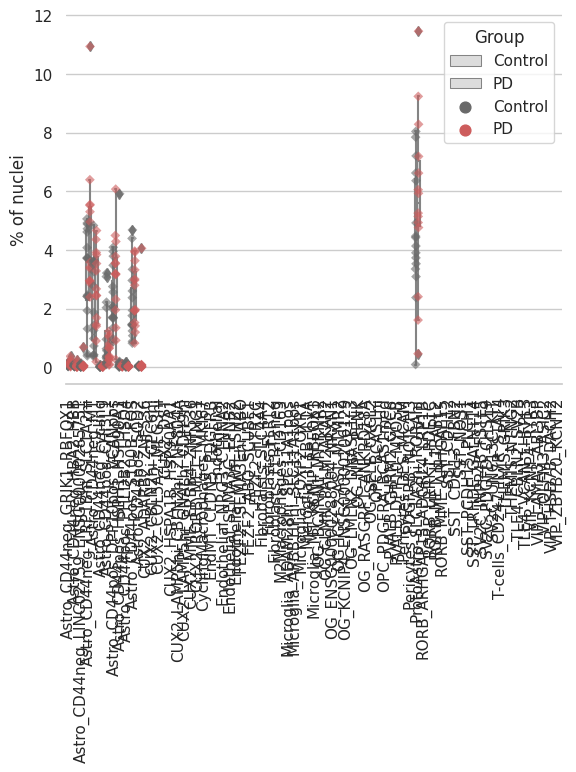

    sample_id                       annotation_level_4    Group  All  \
0     PD0945C               ProtoAstro_SLC1A2hi_RORAhi       PD  786   
1     PD0913C           Astro_CD44neg_LRP1Bhi_SLC1A2hi       PD  783   
2       C074C               ProtoAstro_SLC1A2hi_RORAhi  Control  732   
3       C064C               ProtoAstro_SLC1A2hi_RORAhi  Control  645   
4     PD0590C               ProtoAstro_SLC1A2hi_RORAhi       PD  607   
..        ...                                      ...      ...  ...   
344   PD1101C                    Astro_CD44neg_cycling       PD    1   
345   PD1101C               Astro_CD44pos_PHLDB2_THSD4       PD    1   
346   PDC023C  Astro_CD44neg_LINC02759_ENSG00000285751  Control    1   
347     C036C  Astro_CD44neg_LINC02759_ENSG00000285751  Control    1   
348     C030C               Astro_CD44neg_GRIK1_RBFOX1  Control    1   

     % of nuclei  
0       9.235108  
1       5.303441  
2       8.039539  
3       7.844807  
4       5.931789  
..           ...  
34

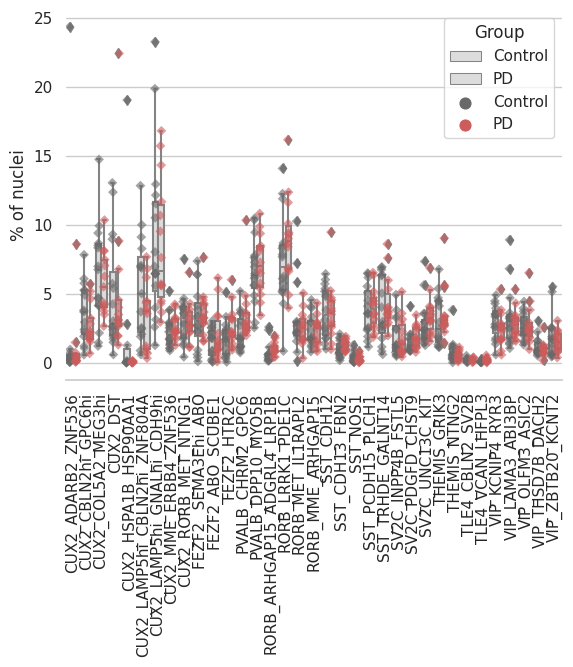

    sample_id          annotation_level_4    Group  All  % of nuclei
0     PD0980C          CUX2_COL5A2_MEG3hi       PD  876    10.357058
1     PD0980C            RORB_LRRK1_PDE1C       PD  854    10.096950
2     PD0980C  CUX2_LAMP5hi_GNALhi_CDH9hi       PD  807     9.541263
3     PD0980C           PVALB_DPP10_MYO5B       PD  718     8.489004
4     PDC085C            RORB_LRRK1_PDE1C  Control  712    14.096219
..        ...                         ...      ...  ...          ...
983   PD0612C             VIP_KCNIP4_RYR3       PD    1     0.862069
984   PD0109C                THEMIS_NTNG2       PD    1     0.099010
985   PD0612C            VIP_ZBTB20_KCNT2       PD    1     0.862069
986     C074C        CUX2_HSPA1B_HSP90AA1  Control    1     0.058106
987   PDC034C          CUX2_ADARB2_ZNF536  Control    1     0.075131

[988 rows x 5 columns]
All


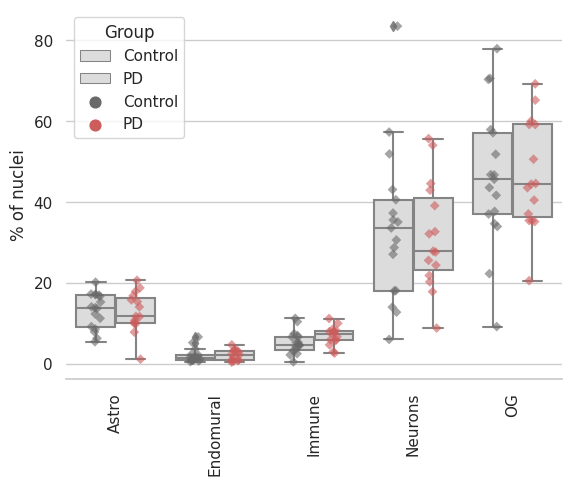

    sample_id annotation_level_1    Group   All  % of nuclei
0     PDC022P                 OG  Control  9047    70.519916
1       C074P                 OG  Control  8480    57.868159
2     PD0980P                 OG       PD  8231    59.134995
3     PDC085P            Neurons  Control  6599    43.035085
4     PD0945P                 OG       PD  6181    65.152314
..        ...                ...      ...   ...          ...
155   PDC034P          Endomural  Control    39     0.506099
156   PD0022P          Endomural       PD    35     0.758232
157   PD0109P          Endomural       PD    33     0.364440
158     C030P             Immune  Control    22     0.424957
159   PD0822P          Endomural       PD    18     0.606265

[160 rows x 5 columns]
All


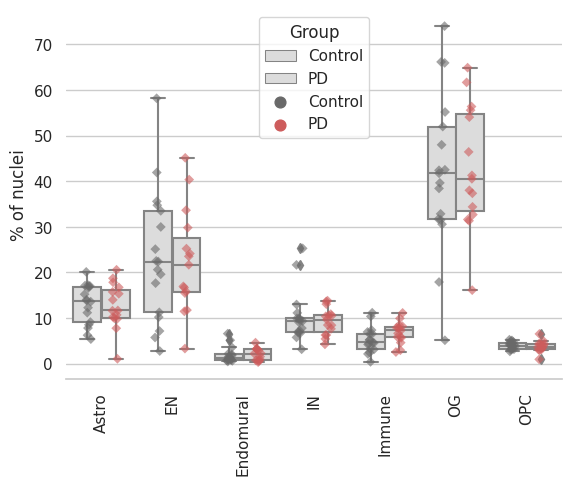

    sample_id annotation_level_2    Group   All  % of nuclei
0     PDC022P                 OG  Control  8456    65.913165
1       C074P                 OG  Control  8082    55.152177
2     PD0980P                 OG       PD  7733    55.557152
3     PD0945P                 OG       PD  5848    61.642247
4     PDC085P                 EN  Control  5138    33.507239
..        ...                ...      ...   ...          ...
219   PDC034P          Endomural  Control    39     0.506099
220   PD0022P          Endomural       PD    35     0.758232
221   PD0109P          Endomural       PD    33     0.364440
222     C030P             Immune  Control    22     0.424957
223   PD0822P          Endomural       PD    18     0.606265

[224 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


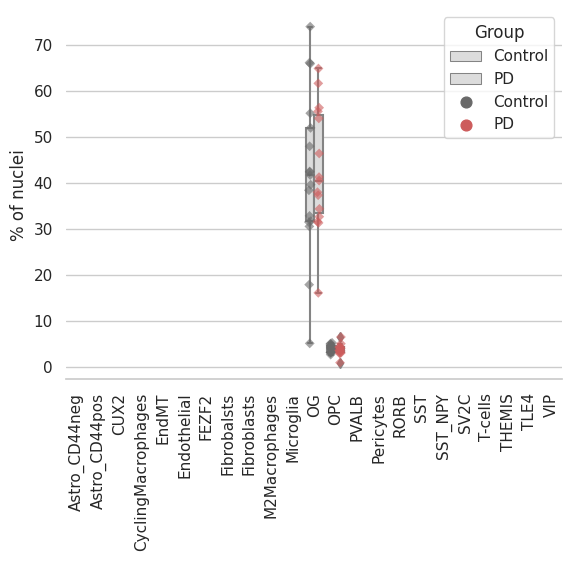

   sample_id annotation_level_3    Group   All  % of nuclei
0    PDC022P                 OG  Control  8456    65.913165
1      C074P                 OG  Control  8082    55.152177
2    PD0980P                 OG       PD  7733    55.557152
3    PD0945P                 OG       PD  5848    61.642247
4    PDC034P                 OG  Control  5096    66.130288
..       ...                ...      ...   ...          ...
59   PD0596P                OPC       PD   188     2.966703
60     C076P                OPC  Control   151     3.907867
61   PD0612P                OPC       PD   131     3.634850
62   PD0822P                OPC       PD   128     4.311216
63   PD0590P                OPC       PD    80     0.975253

[64 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


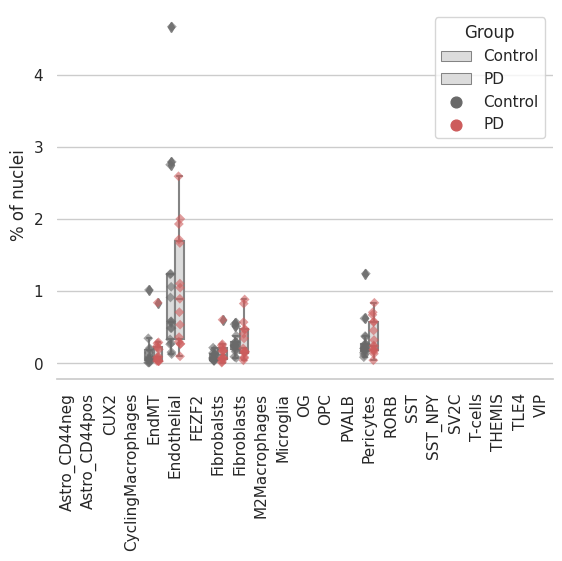

    sample_id annotation_level_3    Group  All  % of nuclei
0     PDC078P        Endothelial  Control  401     4.668762
1       C036P        Endothelial  Control  261     2.754908
2       C064P        Endothelial  Control  255     2.794214
3     PD0687P        Endothelial       PD  234     2.594523
4     PD0590P        Endothelial       PD  137     1.670121
..        ...                ...      ...  ...          ...
147     C075P              EndMT  Control    1     0.017406
148     C049P              EndMT  Control    1     0.011660
149   PD0709P        Fibrobalsts       PD    1     0.012726
150   PD0822P              EndMT       PD    1     0.033681
151   PD0022P        Fibrobalsts       PD    1     0.021664

[152 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


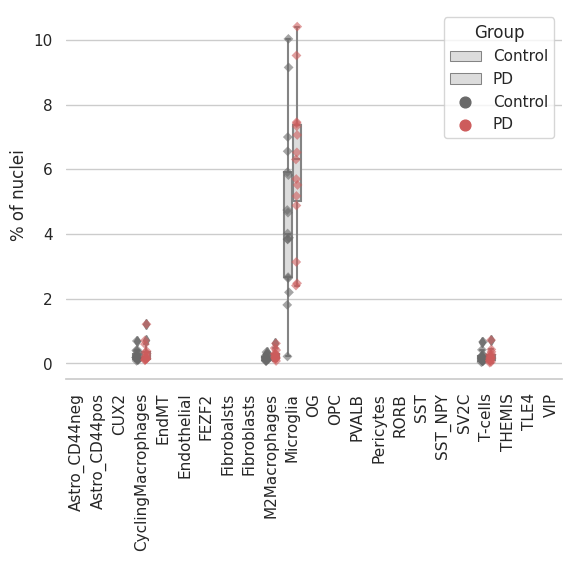

      sample_id  annotation_level_3    Group   All  % of nuclei
0         C074P           Microglia  Control  1025     6.994677
1    C046P_kit5           Microglia  Control   811    10.028441
2       PD0913P           Microglia       PD   757     9.516028
3       PD0980P           Microglia       PD   720     5.172785
4       PD0917P           Microglia       PD   689     7.455903
..          ...                 ...      ...   ...          ...
122       C076P  CyclingMacrophages  Control     4     0.103520
123       C030P  CyclingMacrophages  Control     4     0.077265
124       C030P             T-cells  Control     3     0.057949
125       C075P             T-cells  Control     2     0.034813
126     PD0022P             T-cells       PD     1     0.021664

[127 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


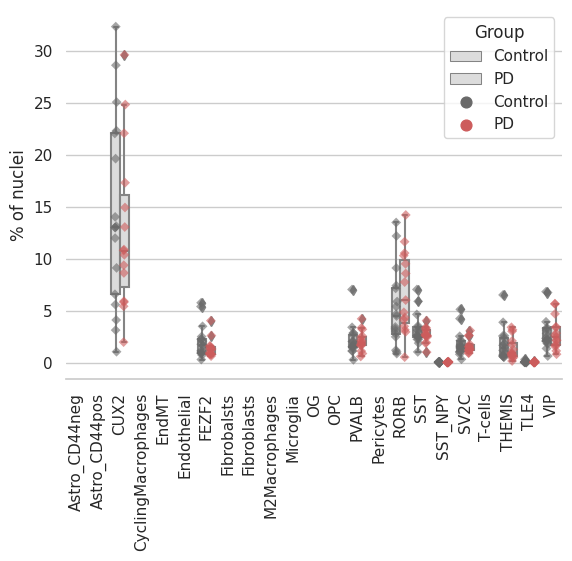

      sample_id annotation_level_3    Group   All  % of nuclei
0         C073P               CUX2  Control  2997    28.638318
1         C036P               CUX2  Control  2377    25.089719
2       PD0086P               CUX2       PD  2214    29.638554
3       PD0590P               CUX2       PD  2039    24.856760
4       PDC085P               RORB  Control  1871    12.201643
..          ...                ...      ...   ...          ...
305       C076P            SST_NPY  Control     1     0.025880
306     PD0976P            SST_NPY       PD     1     0.016529
307     PD0596P            SST_NPY       PD     1     0.015780
308     PDC078P            SST_NPY  Control     1     0.011643
309  C046P_kit5            SST_NPY  Control     1     0.012366

[310 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


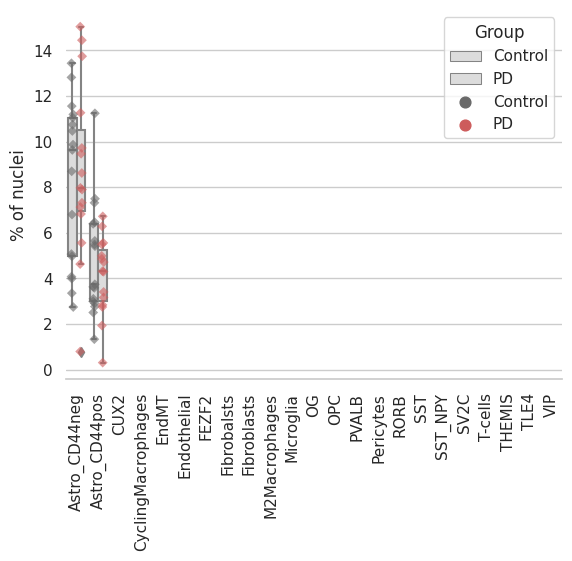

   sample_id annotation_level_3    Group   All  % of nuclei
0      C074P      Astro_CD44neg  Control  1878    12.815613
1    PDC085P      Astro_CD44neg  Control  1647    10.740837
2    PD0109P      Astro_CD44neg       PD  1362    15.041414
3    PD0917P      Astro_CD44neg       PD  1270    13.743101
4      C064P      Astro_CD44neg  Control  1226    13.434144
..       ...                ...      ...   ...          ...
59   PD0822P      Astro_CD44pos       PD   140     4.715392
60     C076P      Astro_CD44neg  Control   106     2.743271
61     C030P      Astro_CD44pos  Control    69     1.332818
62   PD0590P      Astro_CD44neg       PD    65     0.792393
63   PD0590P      Astro_CD44pos       PD    25     0.304767

[64 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


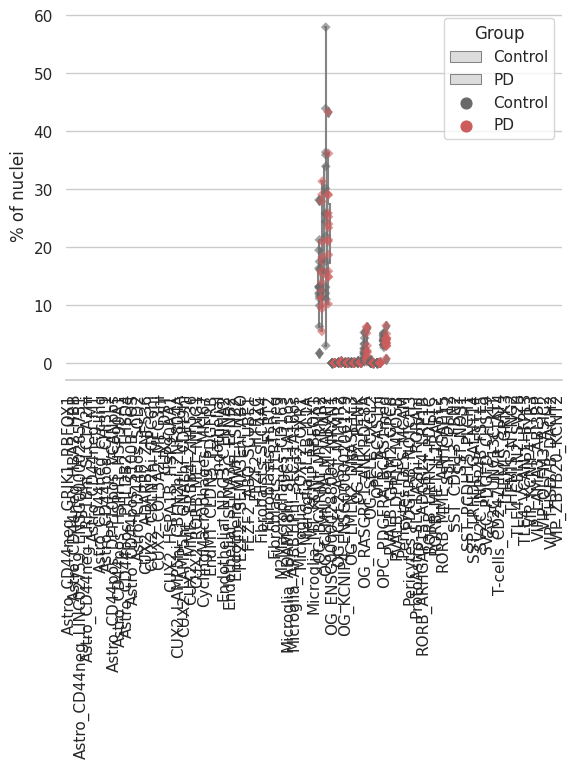

      sample_id         annotation_level_4    Group   All  % of nuclei
0       PDC022P         OG_CLMN_PALM2AKAP2  Control  4671    36.409697
1         C074P         OG_CLMN_PALM2AKAP2  Control  4419    30.155589
2       PD0945P         OG_CLMN_PALM2AKAP2       PD  4112    43.343523
3       PD0980P          OG_BCYRN1_MT-RNR2       PD  3882    27.889935
4       PDC022P          OG_BCYRN1_MT-RNR2  Control  3612    28.154961
..          ...                        ...      ...   ...          ...
322     PD1101P                OPC_BCAS1hi       PD     1     0.014758
323       C036P                OPC_BCAS1hi  Control     1     0.010555
324     PDC035P  OG_KCNIP4_ENSG00000206129  Control     1     0.016075
325  C046P_kit5                OPC_BCAS1hi  Control     1     0.012366
326     PD0687P   OG_ENSG00000288004_NRXN1       PD     1     0.011088

[327 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


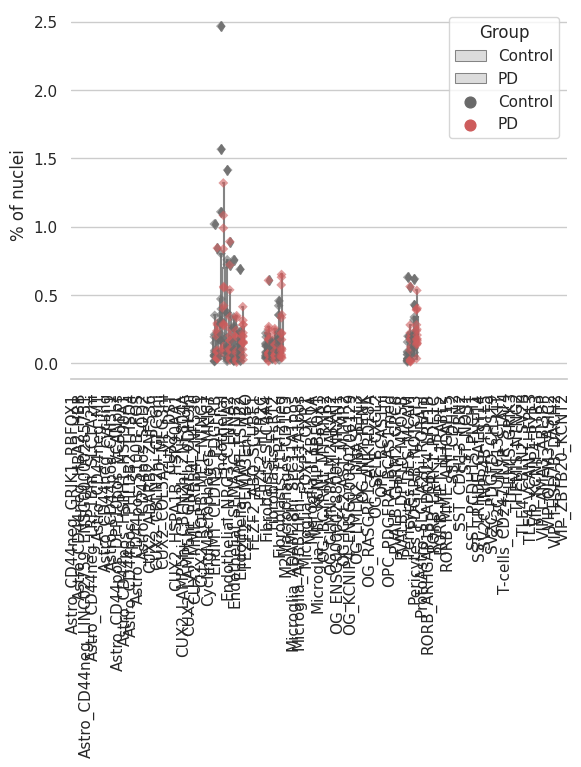

    sample_id       annotation_level_4    Group  All  % of nuclei
0     PDC078P              Endothelial  Control  212     2.468273
1       C064P              Endothelial  Control  143     1.566952
2       C036P  Endothelial_NRG3_CTNNA2  Control  134     1.414397
3     PD0687P              Endothelial       PD  119     1.319437
4       C036P              Endothelial  Control  105     1.108296
..        ...                      ...      ...  ...          ...
293     C075P    Endothelial_VWF_TSHZ2  Control    1     0.017406
294   PD0822P  Endothelial_NRG3_CTNNA2       PD    1     0.033681
295     C075P       EndMT_CLDN5_PDGFRB  Control    1     0.017406
296   PD0709P       Fibrobalsts_SLC4A4       PD    1     0.012726
297   PD0109P       Pericytes_DES_MCAM       PD    1     0.011044

[298 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


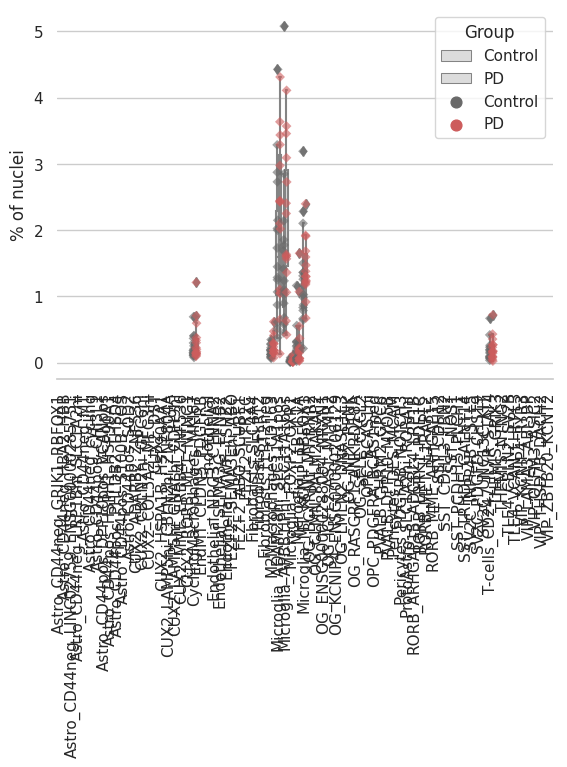

      sample_id              annotation_level_4    Group  All  % of nuclei
0         C074P   Microglia_ADAM28hi_SLC11A1pos  Control  421     2.872936
1    C046P_kit5   Microglia_ADAM28hi_SLC11A1pos  Control  358     4.426858
2       PD0913P   Microglia_ADAM28hi_SLC11A1pos       PD  343     4.311754
3       PDC035P  Microglia_APBB1IPhi_SLC11A1pos  Control  316     5.079569
4         C074P       Microglia_MT_KCNIP_RBFOX1  Control  308     2.101815
..          ...                             ...      ...  ...          ...
236     PD0917P            Microglia_FOXP2_OXR1       PD    1     0.010821
237     PD0945P            Microglia_FOXP2_OXR1       PD    1     0.010541
238     PDC035P            Microglia_FOXP2_OXR1  Control    1     0.016075
239     PD0976P            Microglia_FOXP2_OXR1       PD    1     0.016529
240     PD0687P            Microglia_FOXP2_OXR1       PD    1     0.011088

[241 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


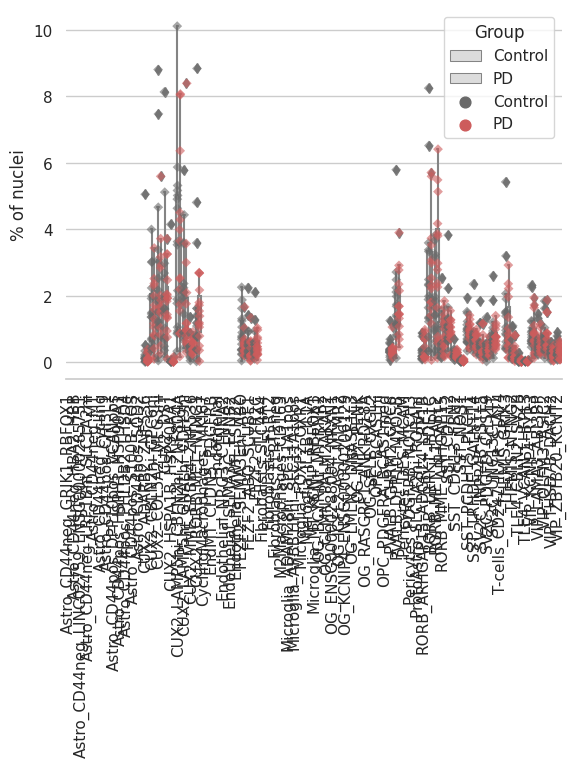

     sample_id            annotation_level_4    Group   All  % of nuclei
0      PDC085P              RORB_LRRK1_PDE1C  Control  1000     6.521456
1        C073P           CUX2_RORB_MET_NTNG1  Control   925     8.838987
2        C073P            CUX2_COL5A2_MEG3hi  Control   782     7.472527
3      PD0709P  CUX2_LAMP5hi_CBLN2hi_ZNF804A       PD   632     8.042759
4      PD0086P    CUX2_LAMP5hi_GNALhi_CDH9hi       PD   627     8.393574
...        ...                           ...      ...   ...          ...
1071     C074P            CUX2_ADARB2_ZNF536  Control     1     0.006824
1072   PD0596P              TLE4_VCAN_LHFPL3       PD     1     0.015780
1073   PD0913P               TLE4_CBLN2_SV2B       PD     1     0.012571
1074     C072P               TLE4_CBLN2_SV2B  Control     1     0.008461
1075     C076P              SV2C_PDGFD_CHST9  Control     1     0.025880

[1076 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


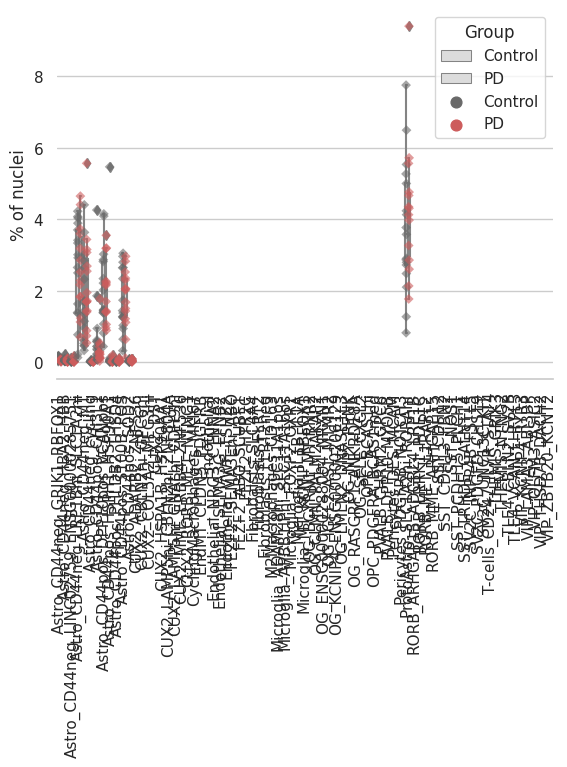

    sample_id                       annotation_level_4    Group   All  \
0       C074P               ProtoAstro_SLC1A2hi_RORAhi  Control  1137   
1     PD0109P               ProtoAstro_SLC1A2hi_RORAhi       PD   852   
2     PDC085P                         Astro_CD44neg_MT  Control   676   
3       C074P           Astro_CD44pos_DPP10pos_VCANpos  Control   609   
4       C064P               ProtoAstro_SLC1A2hi_RORAhi  Control   593   
..        ...                                      ...      ...   ...   
360   PD0612P                   Astro_CD44neg_HBA2_HBB       PD     1   
361     C064P  Astro_CD44neg_LINC02759_ENSG00000285751  Control     1   
362   PD0612P  Astro_CD44neg_LINC02759_ENSG00000285751       PD     1   
363   PDC034P                    Astro_CD44neg_cycling  Control     1   
364     C030P               Astro_CD44neg_GRIK1_RBFOX1  Control     1   

     % of nuclei  
0       7.758974  
1       9.409166  
2       4.408504  
3       4.155862  
4       6.497918  
..       

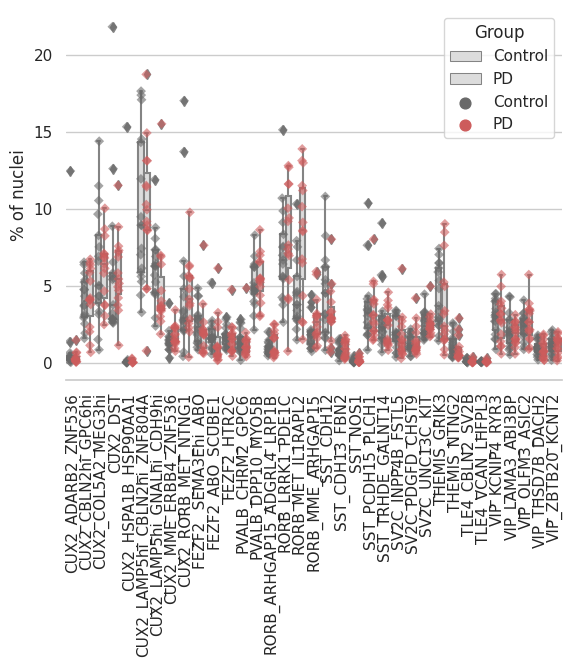

     sample_id            annotation_level_4    Group   All  % of nuclei
0      PDC085P              RORB_LRRK1_PDE1C  Control  1000    15.153811
1        C073P           CUX2_RORB_MET_NTNG1  Control   925    17.047549
2        C073P            CUX2_COL5A2_MEG3hi  Control   782    14.412090
3      PD0709P  CUX2_LAMP5hi_CBLN2hi_ZNF804A       PD   632    18.753709
4      PD0086P    CUX2_LAMP5hi_GNALhi_CDH9hi       PD   627    15.542885
...        ...                           ...      ...   ...          ...
1071     C074P            CUX2_ADARB2_ZNF536  Control     1     0.048876
1072   PD0596P              TLE4_VCAN_LHFPL3       PD     1     0.048356
1073   PD0913P               TLE4_CBLN2_SV2B       PD     1     0.039170
1074     C072P               TLE4_CBLN2_SV2B  Control     1     0.023815
1075     C076P              SV2C_PDGFD_CHST9  Control     1     0.432900

[1076 rows x 5 columns]
All


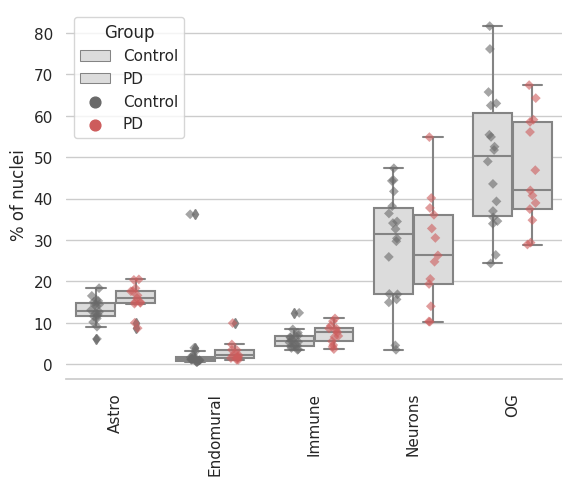

    sample_id annotation_level_1    Group    All  % of nuclei
0     PDC085F                 OG  Control  10043    55.421886
1     PDC078F                 OG  Control   6559    65.754386
2       C072F                 OG  Control   6376    52.542233
3     PDC029F                 OG  Control   6318    76.157184
4     PDC034F                 OG  Control   5861    81.675028
..        ...                ...      ...    ...          ...
150   PD0779F          Endomural       PD     56     1.039154
151   PDC022F          Endomural  Control     55     0.534967
152     C030F          Endomural  Control     54     1.347305
153     C049F          Endomural  Control     52     0.657562
154     C075F          Endomural  Control     40     1.271052

[155 rows x 5 columns]
All


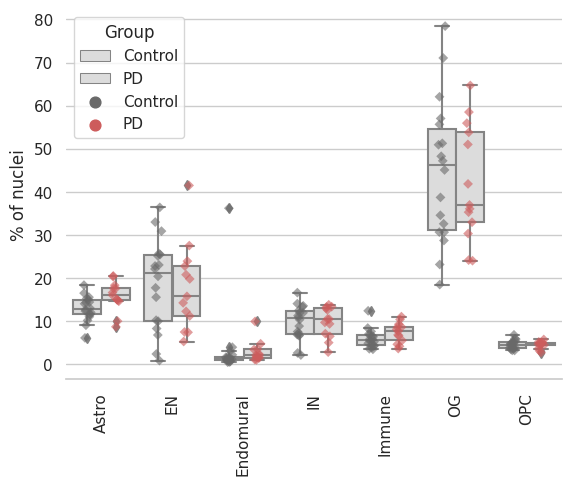

    sample_id annotation_level_2    Group   All  % of nuclei
0     PDC085F                 OG  Control  9291    51.272005
1     PDC078F                 OG  Control  6191    62.065163
2     PDC029F                 OG  Control  5896    71.070395
3       C072F                 OG  Control  5729    47.210548
4     PDC034F                 OG  Control  5630    78.455964
..        ...                ...      ...   ...          ...
212   PD0779F          Endomural       PD    56     1.039154
213   PDC022F          Endomural  Control    55     0.534967
214     C030F          Endomural  Control    54     1.347305
215     C049F          Endomural  Control    52     0.657562
216     C075F          Endomural  Control    40     1.271052

[217 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


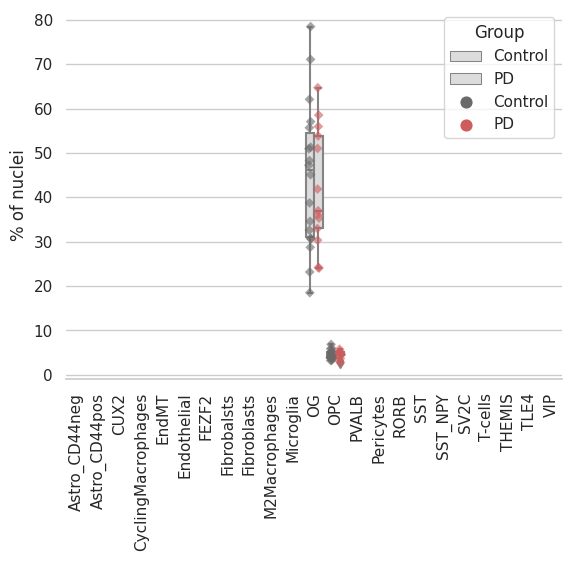

   sample_id annotation_level_3    Group   All  % of nuclei
0    PDC085F                 OG  Control  9291    51.272005
1    PDC078F                 OG  Control  6191    62.065163
2    PDC029F                 OG  Control  5896    71.070395
3      C072F                 OG  Control  5729    47.210548
4    PDC034F                 OG  Control  5630    78.455964
..       ...                ...      ...   ...          ...
57     C075F                OPC  Control   188     5.973943
58   PD0612F                OPC       PD   158     5.764320
59     C076F                OPC  Control   155     4.772167
60   PD0802F                OPC       PD   113     2.734753
61   PD0822F                OPC       PD   112     3.667322

[62 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


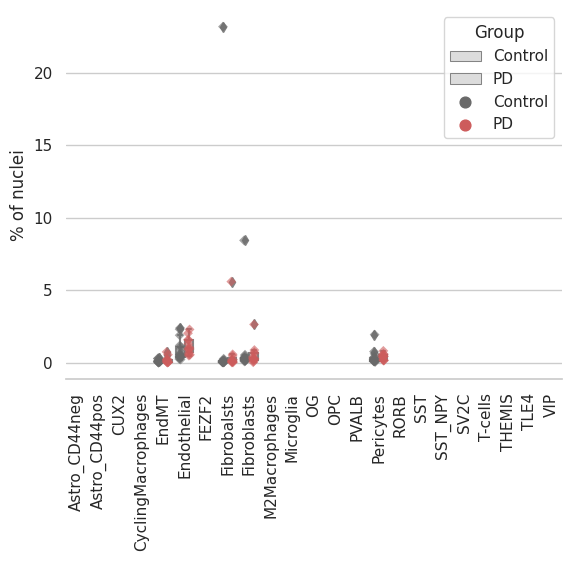

    sample_id annotation_level_3    Group   All  % of nuclei
0     PDC035F        Fibrobalsts  Control  1563    23.162418
1     PDC035F        Fibroblasts  Control   569     8.432128
2     PD0802F        Fibrobalsts       PD   231     5.590513
3     PD0709F        Endothelial       PD   197     2.293097
4     PDC035F        Endothelial  Control   162     2.400711
..        ...                ...      ...   ...          ...
144     C074F              EndMT  Control     1     0.011128
145     C073F              EndMT  Control     1     0.012867
146   PD0022F        Fibrobalsts       PD     1     0.022635
147   PD0086F        Fibrobalsts       PD     1     0.017690
148   PD0109F              EndMT       PD     1     0.007070

[149 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


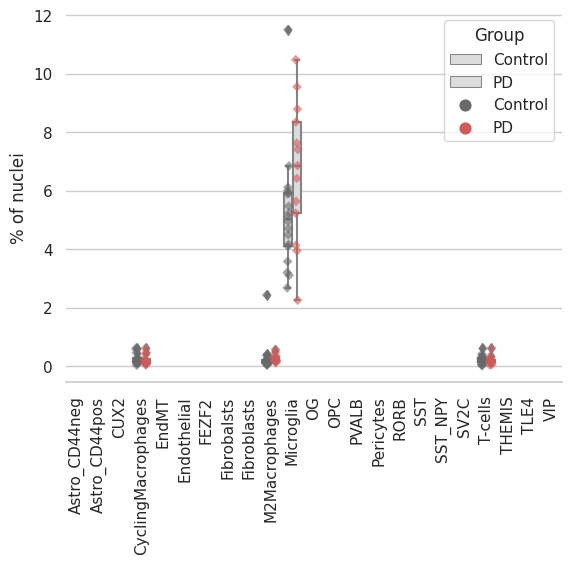

    sample_id  annotation_level_3    Group  All  % of nuclei
0     PD0913F           Microglia       PD  871     9.551486
1       C046F           Microglia  Control  800    11.507480
2     PD0109F           Microglia       PD  797     5.634500
3     PD0709F           Microglia       PD  755     8.788267
4     PD0980F           Microglia       PD  735     7.405542
..        ...                 ...      ...  ...          ...
119   PD0822F  CyclingMacrophages       PD    3     0.098232
120   PD0086F             T-cells       PD    2     0.035379
121     C075F             T-cells  Control    1     0.031776
122     C076F  CyclingMacrophages  Control    1     0.030788
123   PDC034F             T-cells  Control    1     0.013935

[124 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


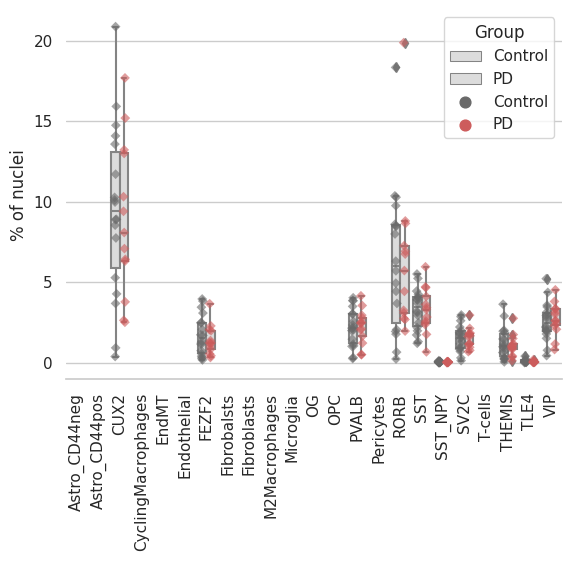

    sample_id annotation_level_3    Group   All  % of nuclei
0     PDC085F               CUX2  Control  1861    10.269853
1     PD0596F               RORB       PD  1410    19.875952
2     PD0980F               CUX2       PD  1290    12.997481
3       C046F               RORB  Control  1275    18.340046
4       C049F               CUX2  Control  1259    15.920587
..        ...                ...      ...   ...          ...
296     C076F            SST_NPY  Control     1     0.030788
297     C049F            SST_NPY  Control     1     0.012645
298   PDC027F               TLE4  Control     1     0.012038
299   PD0022F               TLE4       PD     1     0.022635
300   PDC034F            SST_NPY  Control     1     0.013935

[301 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


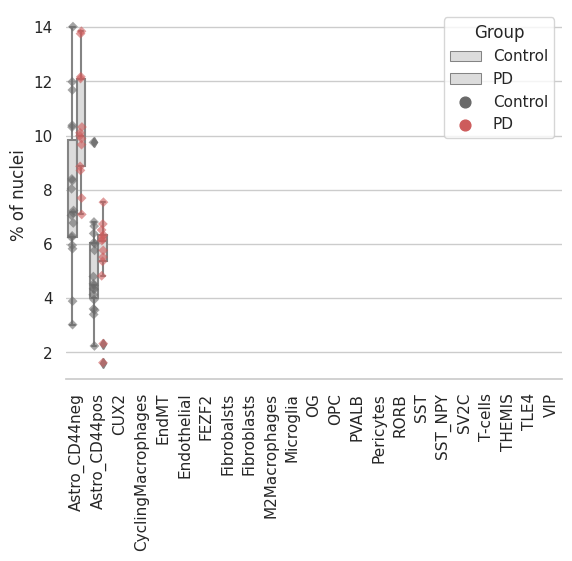

   sample_id annotation_level_3    Group   All  % of nuclei
0    PD0109F      Astro_CD44neg       PD  1722    12.173913
1    PDC085F      Astro_CD44neg  Control  1228     6.776668
2      C074F      Astro_CD44neg  Control  1077    11.985310
3      C064F      Astro_CD44neg  Control  1073    14.022478
4    PD0980F      Astro_CD44neg       PD   992     9.994962
..       ...                ...      ...   ...          ...
57   PD0779C      Astro_CD44pos  Control   187     3.561226
58   PD0596F      Astro_CD44pos       PD   165     2.325909
59   PD0612F      Astro_CD44pos       PD   158     5.764320
60     C076F      Astro_CD44pos  Control   134     4.125616
61   PD0802F      Astro_CD44pos       PD    67     1.621491

[62 rows x 5 columns]
OG


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


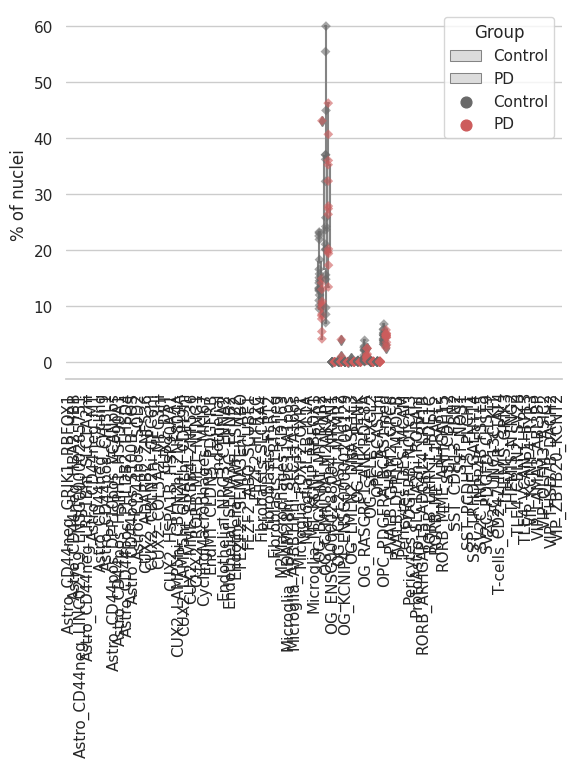

    sample_id         annotation_level_4    Group   All  % of nuclei
0     PDC029F         OG_CLMN_PALM2AKAP2  Control  4605    55.508679
1     PDC034F         OG_CLMN_PALM2AKAP2  Control  4310    60.061315
2     PDC085F         OG_CLMN_PALM2AKAP2  Control  4292    23.685227
3     PDC085F          OG_BCYRN1_MT-RNR2  Control  4215    23.260306
4       C072F         OG_CLMN_PALM2AKAP2  Control  3921    32.311496
..        ...                        ...      ...   ...          ...
301     C064F  OG_KCNIP4_ENSG00000206129  Control     1     0.013068
302     C049F  OG_KCNIP4_ENSG00000206129  Control     1     0.012645
303   PDC022F                OPC_BCAS1hi  Control     1     0.009727
304   PDC027F  OG_KCNIP4_ENSG00000206129  Control     1     0.012038
305     C075F                OPC_BCAS1hi  Control     1     0.031776

[306 rows x 5 columns]
Endomural


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


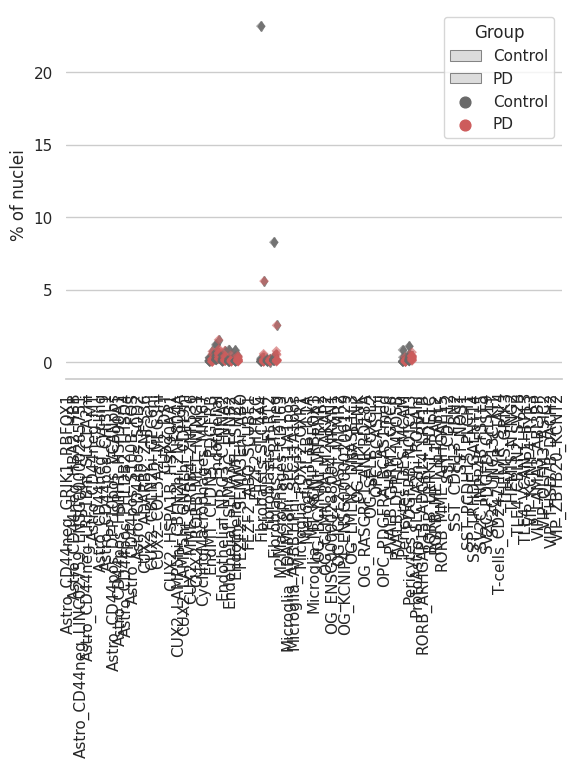

    sample_id       annotation_level_4    Group   All  % of nuclei
0     PDC035F       Fibrobalsts_SLC4A4  Control  1563    23.162418
1     PDC035F     Fibroblasts_FLRT2neg  Control   558     8.269117
2     PD0802F       Fibrobalsts_SLC4A4       PD   231     5.590513
3     PD0802F     Fibroblasts_FLRT2neg       PD   105     2.541142
4     PD0980F              Endothelial       PD    91     0.916877
..        ...                      ...      ...   ...          ...
291   PD0086F       Fibrobalsts_SLC4A4       PD     1     0.017690
292     C075F  Endothelial_NRG3_CTNNA2  Control     1     0.031776
293     C075F    Endothelial_VWF_TSHZ2  Control     1     0.031776
294     C075F       Fibrobalsts_SLC4A4  Control     1     0.031776
295   PDC022F        Fibroblasts_FLRT2  Control     1     0.009727

[296 rows x 5 columns]
Immune


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


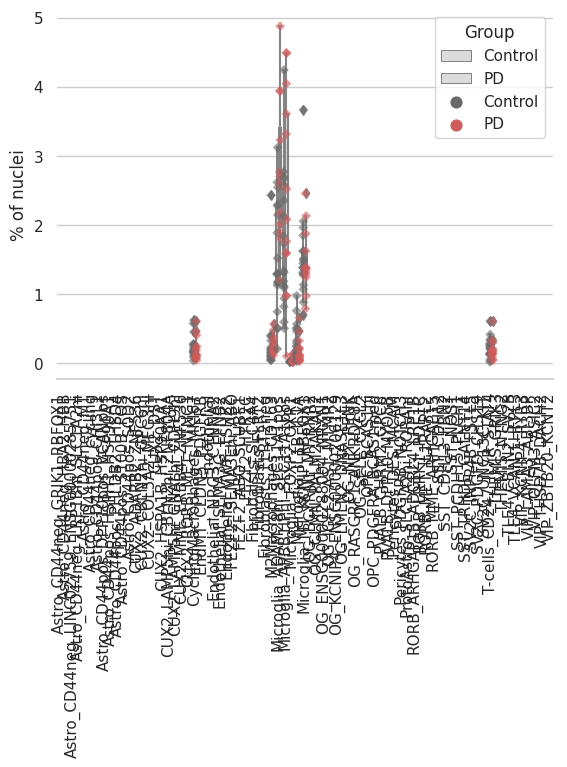

    sample_id              annotation_level_4    Group  All  % of nuclei
0     PD0109F   Microglia_ADAM28hi_SLC11A1pos       PD  382     2.700601
1     PD0913F  Microglia_APBB1IPhi_SLC11A1pos       PD  369     4.046496
2     PD0913F   Microglia_ADAM28hi_SLC11A1pos       PD  359     3.936835
3     PD0980F  Microglia_APBB1IPhi_SLC11A1pos       PD  329     3.314861
4     PD0709F  Microglia_APBB1IPhi_SLC11A1pos       PD  310     3.608427
..        ...                             ...      ...  ...          ...
230   PDC035F            Microglia_FOXP2_OXR1  Control    1     0.014819
231   PD0802F             Microglia_IL1B_IL1A       PD    1     0.024201
232   PD0917F            Microglia_FOXP2_OXR1       PD    1     0.012798
233   PDC034F        T-cells_CD247_IL7R_STAT4  Control    1     0.013935
234   PD0687F            Microglia_FOXP2_OXR1       PD    1     0.013501

[235 rows x 5 columns]
Neurons


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


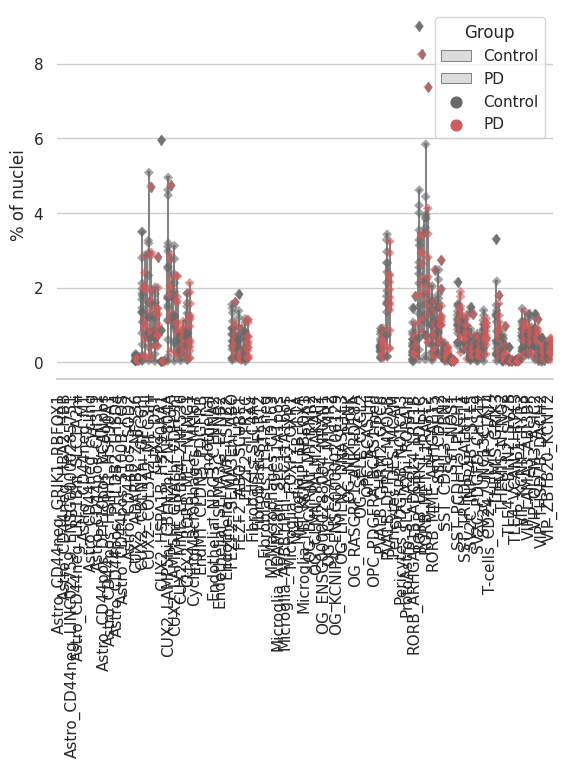

     sample_id    annotation_level_4    Group  All  % of nuclei
0        C046F      RORB_LRRK1_PDE1C  Control  626     9.004603
1      PDC085F          THEMIS_GRIK3  Control  599     3.305557
2      PD0596F      RORB_LRRK1_PDE1C       PD  585     8.246405
3      PDC085F      RORB_LRRK1_PDE1C  Control  568     3.134485
4      PD0596F     RORB_MET_IL1RAPL2       PD  523     7.372427
...        ...                   ...      ...  ...          ...
1035   PD0612F        SST_CDH13_FBN2       PD    1     0.036483
1036     C049F              SST_NOS1  Control    1     0.012645
1037   PD0687F  CUX2_HSPA1B_HSP90AA1       PD    1     0.013501
1038   PD0687F              SST_NOS1       PD    1     0.013501
1039     C072F  CUX2_HSPA1B_HSP90AA1  Control    1     0.008241

[1040 rows x 5 columns]
Astro


/home/MRMelissaGrantPeters/miniconda3/envs/panpipes-hardy/lib/python3.8/site-packages/seaborn/categorical.py:1143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  hue_mask = self.plot_hues[i] == hue_level


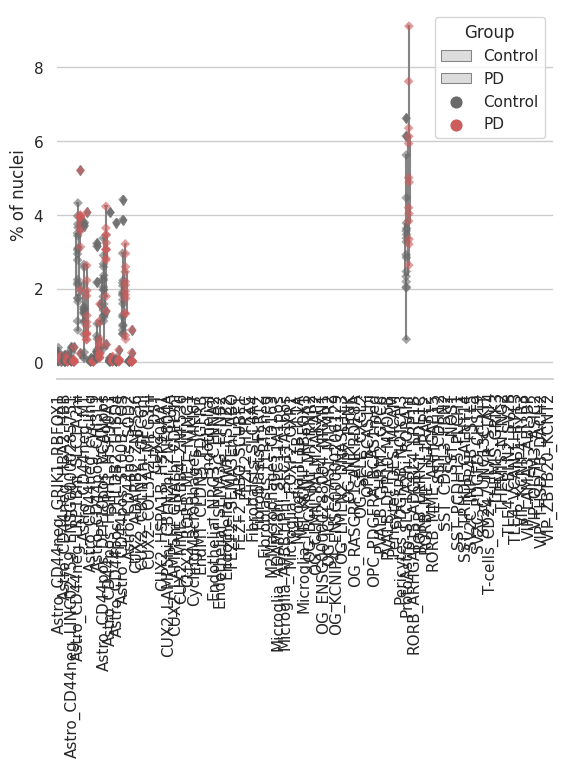

    sample_id              annotation_level_4    Group  All  % of nuclei
0     PD0109F      ProtoAstro_SLC1A2hi_RORAhi       PD  899     6.355603
1       C074F      ProtoAstro_SLC1A2hi_RORAhi  Control  595     6.621411
2     PD0109F  Astro_CD44neg_LRP1Bhi_SLC1A2hi       PD  556     3.930718
3     PD0709F      ProtoAstro_SLC1A2hi_RORAhi       PD  510     5.936445
4     PD0109F  Astro_CD44pos_DPP10pos_VCANpos       PD  490     3.464122
..        ...                             ...      ...  ...          ...
343     C074F          Astro_CD44neg_HBA2_HBB  Control    1     0.011128
344   PD0913F      Astro_CD44pos_PHLDB2_THSD4       PD    1     0.010966
345     C036F      Astro_CD44pos_PHLDB2_THSD4  Control    1     0.018440
346   PD0913F     Astro_CD44pos_HSPH1_HSP90A1       PD    1     0.010966
347   PDC029F      Astro_CD44neg_GRIK1_RBFOX1  Control    1     0.012054

[348 rows x 5 columns]
Neurons


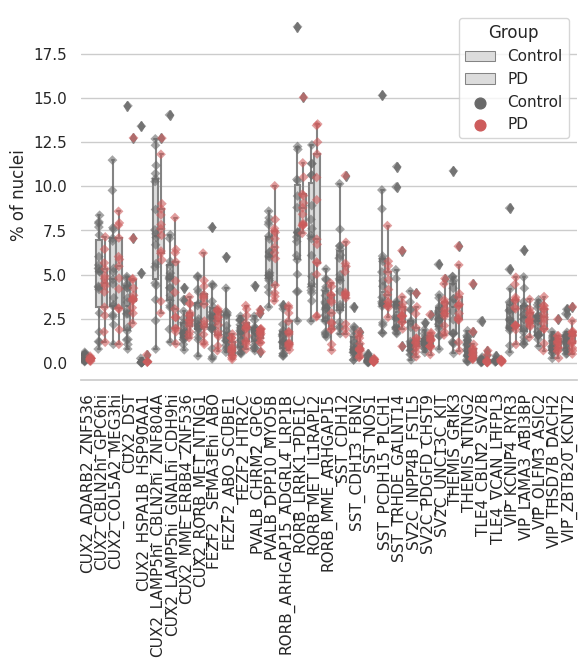

     sample_id    annotation_level_4    Group  All  % of nuclei
0        C046F      RORB_LRRK1_PDE1C  Control  626    19.021574
1      PDC085F          THEMIS_GRIK3  Control  599    10.871143
2      PD0596F      RORB_LRRK1_PDE1C       PD  585    15.030832
3      PDC085F      RORB_LRRK1_PDE1C  Control  568    10.308530
4      PD0596F     RORB_MET_IL1RAPL2       PD  523    13.437821
...        ...                   ...      ...  ...          ...
1035   PD0612F        SST_CDH13_FBN2       PD    1     0.353357
1036     C049F              SST_NOS1  Control    1     0.030285
1037   PD0687F  CUX2_HSPA1B_HSP90AA1       PD    1     0.065531
1038   PD0687F              SST_NOS1       PD    1     0.065531
1039     C072F  CUX2_HSPA1B_HSP90AA1  Control    1     0.027739

[1040 rows x 5 columns]
Done.


<Figure size 640x480 with 0 Axes>

In [12]:
boxplots_clusters(adata, 'All', ['All'], 'annotation_level_1', 'all_cortex', "gainsboro")
boxplots_clusters(adata, 'All', ['All'], 'annotation_level_2', 'all_cortex', "gainsboro")
boxplots_clusters(adata, 'annotation_level_1', buckets, 'annotation_level_3', 'all_cortex', "gainsboro")
boxplots_clusters(adata, 'annotation_level_1', buckets, 'annotation_level_4', 'all_cortex', "gainsboro")
neurons = adata[adata.obs['annotation_level_1']=='Neurons']
boxplots_clusters(neurons, 'annotation_level_1', ['Neurons'], 'annotation_level_4', 'all_cortex', "gainsboro")

boxplots_clusters(adata[adata.obs['region']=='C'], 'All', ['All'], 'annotation_level_1', 'C', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='C'], 'All', ['All'], 'annotation_level_2', 'C', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='C'], 'annotation_level_1', buckets, 'annotation_level_3', 'C', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='C'], 'annotation_level_1', buckets, 'annotation_level_4', 'C', "gainsboro")
subset = adata[adata.obs['region']=='C']
neurons = subset[subset.obs['annotation_level_1']=='Neurons']
boxplots_clusters(neurons, 'annotation_level_1', ['Neurons'], 'annotation_level_4', 'C', "gainsboro")

boxplots_clusters(adata[adata.obs['region']=='P'], 'All', ['All'], 'annotation_level_1', 'P', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='P'], 'All', ['All'], 'annotation_level_2', 'P', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='P'], 'annotation_level_1', buckets, 'annotation_level_3', 'P', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='P'], 'annotation_level_1', buckets, 'annotation_level_4', 'P', "gainsboro")
subset = adata[adata.obs['region']=='P']
neurons = subset[subset.obs['annotation_level_1']=='Neurons']
boxplots_clusters(neurons, 'annotation_level_1', ['Neurons'], 'annotation_level_4', 'P', "gainsboro")

boxplots_clusters(adata[adata.obs['region']=='F'], 'All', ['All'], 'annotation_level_1', 'F', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='F'], 'All', ['All'], 'annotation_level_2', 'F', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='F'], 'annotation_level_1', buckets, 'annotation_level_3', 'F', "gainsboro")
boxplots_clusters(adata[adata.obs['region']=='F'], 'annotation_level_1', buckets, 'annotation_level_4', 'F', "gainsboro")
subset = adata[adata.obs['region']=='F']
neurons = subset[subset.obs['annotation_level_1']=='Neurons']
boxplots_clusters(neurons, 'annotation_level_1', ['Neurons'], 'annotation_level_4', 'F', "gainsboro")

print('Done.')